In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [11]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr)
        x_cls = discriminator(x)
        
        # adversarial loss
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + _dis + _mae + _ssim + air_loss + bone_loss
                        
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        _loss.backward()
        
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [12]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [13]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [15]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [16]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [17]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [18]:
len(trainset), len(testset)

(1344, 191)

In [19]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f570e920a60>,)

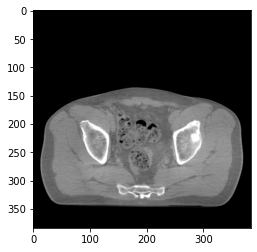

In [20]:
plt.imshow(x.squeeze(), 'gray'),

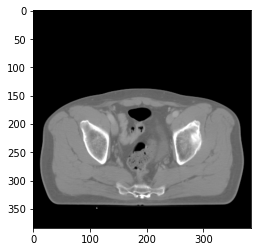

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [23]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [26]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [28]:
wandb.watch(model)
wandb.watch(discriminator)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

168it [02:39,  1.05it/s]
168it [00:47,  3.53it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.05it/s]
168it [00:47,  3.51it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.51it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.05it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.35it/s]
168it [02:40,  1.04it/s]
168it [00:48,

In [29]:
checkpoint = torch.load(os.path.join("{}.pth".format(wandb.run.name)))

In [30]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [31]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8881003260612488
psnr score = 25.617942810058594
snr score = 15.68088150024414
mae error = 0.01731734909117222
air dice score = 0.9979823001777993
bone dice score = 0.933683903010025


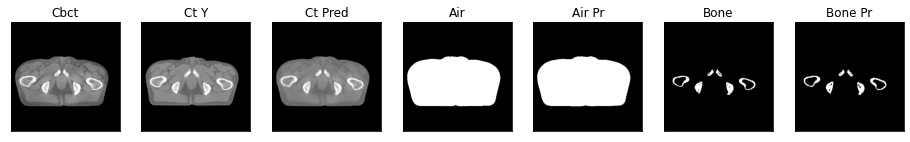

ssim score = 0.8887891173362732
psnr score = 25.546794891357422
snr score = 15.657267570495605
mae error = 0.01742129772901535
air dice score = 0.998192512407755
bone dice score = 0.939772890614636


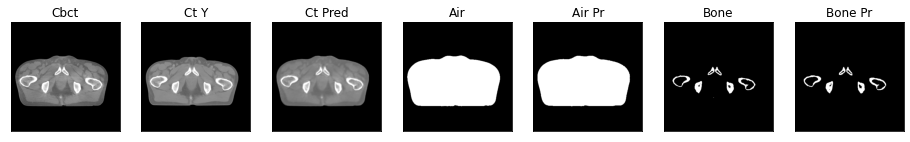

ssim score = 0.8876372575759888
psnr score = 25.484590530395508
snr score = 15.757960319519043
mae error = 0.018092487007379532
air dice score = 0.9982711928769167
bone dice score = 0.9320551228288548


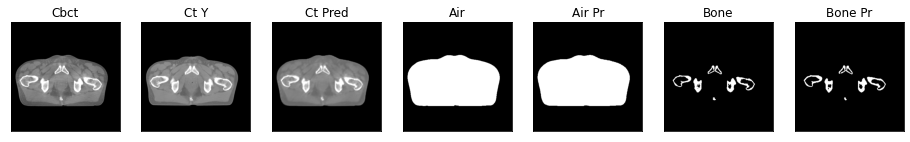

ssim score = 0.8860940337181091
psnr score = 25.596389770507812
snr score = 15.959013938903809
mae error = 0.018002310767769814
air dice score = 0.9983385046541904
bone dice score = 0.9234065345482227


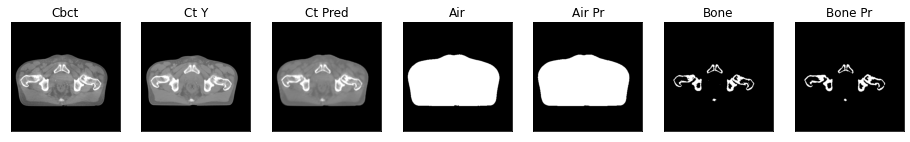

ssim score = 0.8861768841743469
psnr score = 25.79861068725586
snr score = 16.201536178588867
mae error = 0.017905859276652336
air dice score = 0.9984337663902347
bone dice score = 0.9237133237140576


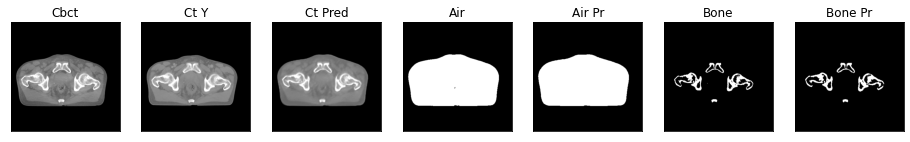

ssim score = 0.8788262009620667
psnr score = 25.65801429748535
snr score = 16.197473526000977
mae error = 0.018757397308945656
air dice score = 0.9983668367038345
bone dice score = 0.9238313174246172


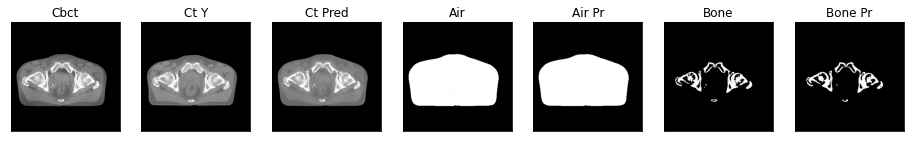

ssim score = 0.8783050179481506
psnr score = 25.548904418945312
snr score = 16.064306259155273
mae error = 0.01889958418905735
air dice score = 0.9977971555898468
bone dice score = 0.9303643087581213


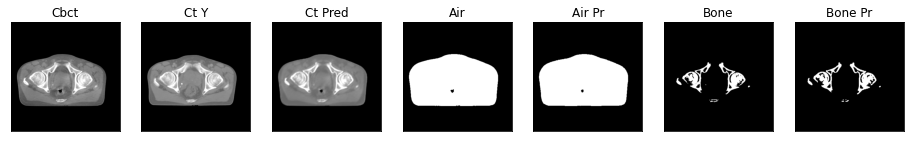

ssim score = 0.8814722895622253
psnr score = 25.883310317993164
snr score = 16.213172912597656
mae error = 0.018202416598796844
air dice score = 0.9976402325035012
bone dice score = 0.9338778347386056


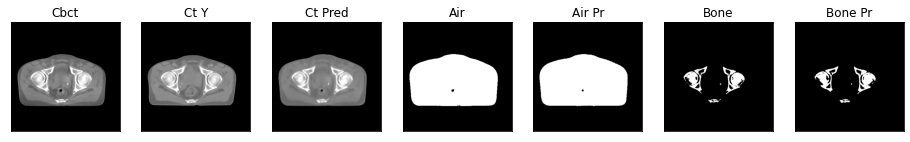

1it [00:02,  2.83s/it]

ssim score = 0.8856874704360962
psnr score = 26.254467010498047
snr score = 16.489776611328125
mae error = 0.01731272228062153
air dice score = 0.9979250128402692
bone dice score = 0.9380834444662023


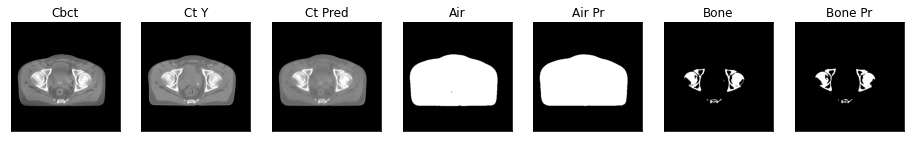

ssim score = 0.8895115852355957
psnr score = 26.38158416748047
snr score = 16.601612091064453
mae error = 0.01702636294066906
air dice score = 0.99768120742842
bone dice score = 0.9377962085314199


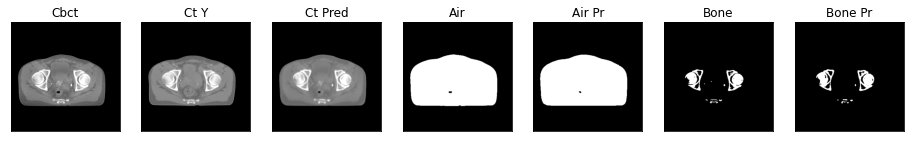

ssim score = 0.8960742950439453
psnr score = 26.71846580505371
snr score = 16.970762252807617
mae error = 0.016426006332039833
air dice score = 0.9976050148905621
bone dice score = 0.9503276262951773


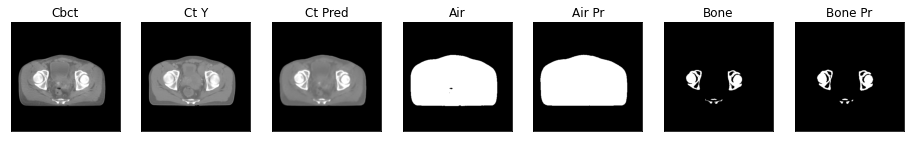

ssim score = 0.8955624103546143
psnr score = 26.029632568359375
snr score = 16.305639266967773
mae error = 0.017154967412352562
air dice score = 0.9976608433608015
bone dice score = 0.9540718690202629


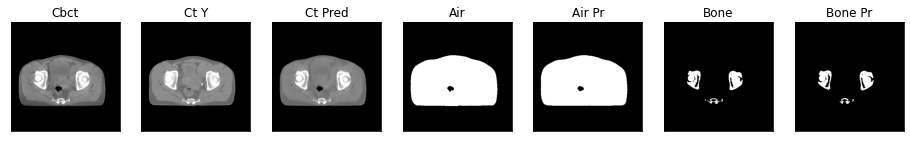

ssim score = 0.9017488360404968
psnr score = 25.45963478088379
snr score = 15.703720092773438
mae error = 0.017239460721611977
air dice score = 0.9977941881653424
bone dice score = 0.9610595426764652


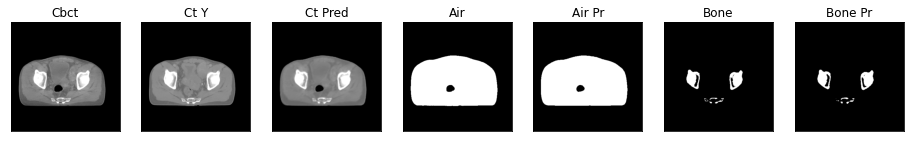

ssim score = 0.8979707956314087
psnr score = 25.086620330810547
snr score = 15.18874740600586
mae error = 0.01791548915207386
air dice score = 0.9980453227365502
bone dice score = 0.9402460456949505


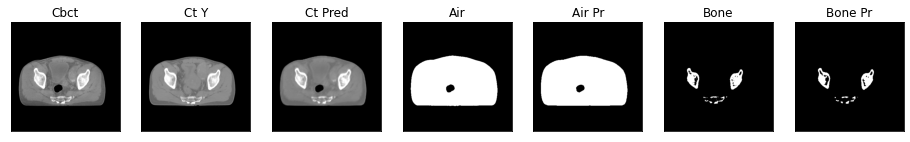

ssim score = 0.8952855467796326
psnr score = 24.94854736328125
snr score = 14.96501350402832
mae error = 0.018201112747192383
air dice score = 0.9978705235053151
bone dice score = 0.92071475843917


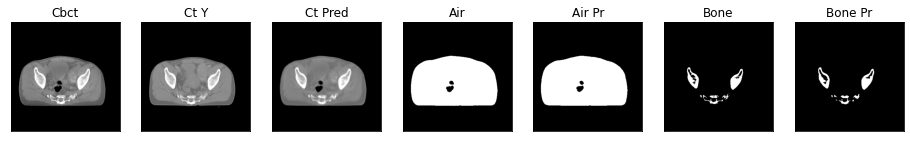

ssim score = 0.8899683356285095
psnr score = 24.591140747070312
snr score = 14.63109016418457
mae error = 0.019018961116671562
air dice score = 0.9978276925750555
bone dice score = 0.9318664833112655


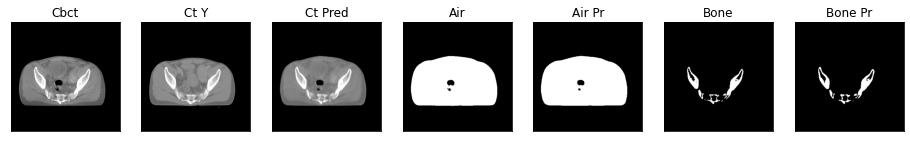

2it [00:05,  2.66s/it]

ssim score = 0.8857769966125488
psnr score = 23.8663330078125
snr score = 13.903740882873535
mae error = 0.020187558606266975
air dice score = 0.9978451119222504
bone dice score = 0.926618705036851


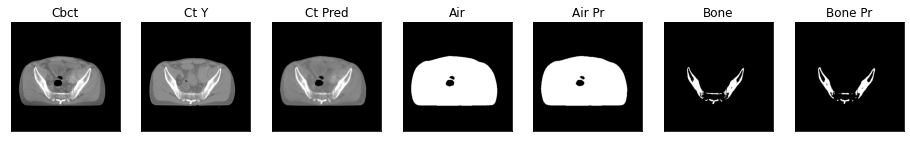

ssim score = 0.8790110349655151
psnr score = 23.290950775146484
snr score = 13.22659683227539
mae error = 0.021438196301460266
air dice score = 0.9967363578644901
bone dice score = 0.9080698327443771


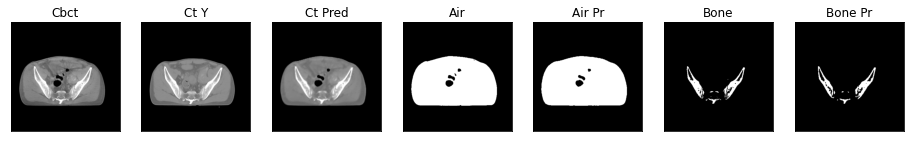

ssim score = 0.8772502541542053
psnr score = 22.99314308166504
snr score = 12.878108024597168
mae error = 0.02204773761332035
air dice score = 0.9964926480507257
bone dice score = 0.905074626866805


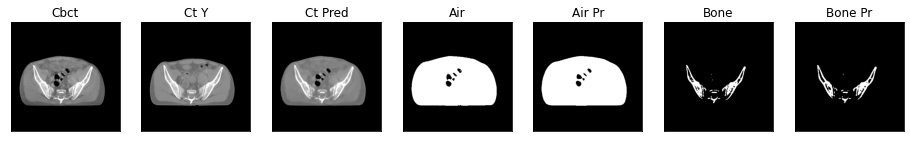

ssim score = 0.8799756765365601
psnr score = 22.967166900634766
snr score = 12.839820861816406
mae error = 0.022175561636686325
air dice score = 0.996858970013336
bone dice score = 0.9146983233396806


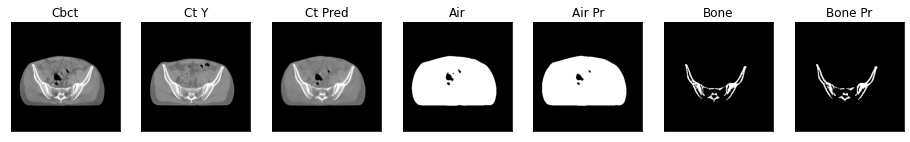

ssim score = 0.8776162266731262
psnr score = 22.801475524902344
snr score = 12.609283447265625
mae error = 0.022342588752508163
air dice score = 0.997656054434156
bone dice score = 0.9039563074476628


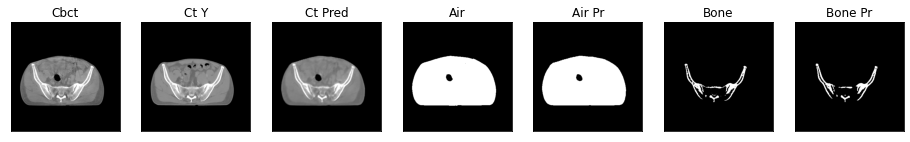

ssim score = 0.8749767541885376
psnr score = 22.830036163330078
snr score = 12.578413009643555
mae error = 0.021964089944958687
air dice score = 0.996336239074761
bone dice score = 0.9114420062707492


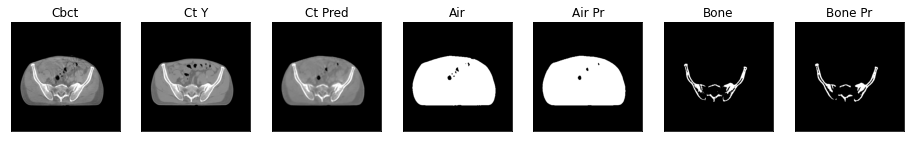

ssim score = 0.877446174621582
psnr score = 22.884939193725586
snr score = 12.599888801574707
mae error = 0.021749434992671013
air dice score = 0.9970711151757944
bone dice score = 0.9099132135446778


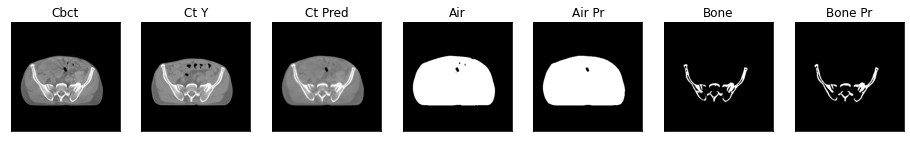

ssim score = 0.8784326910972595
psnr score = 22.854644775390625
snr score = 12.521032333374023
mae error = 0.021968035027384758
air dice score = 0.9963759644610751
bone dice score = 0.9042553191500678


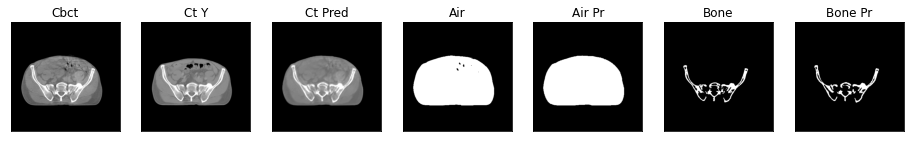

3it [00:07,  2.48s/it]

ssim score = 0.8795773983001709
psnr score = 22.825834274291992
snr score = 12.395223617553711
mae error = 0.021876530721783638
air dice score = 0.9978416071725079
bone dice score = 0.9047129978328801


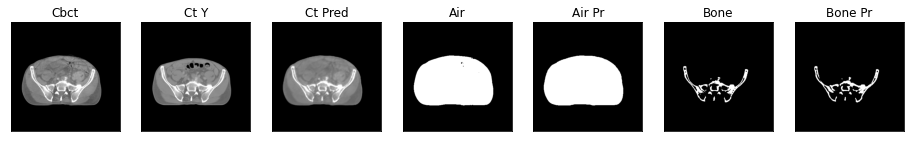

ssim score = 0.8817899823188782
psnr score = 23.04924964904785
snr score = 12.53590202331543
mae error = 0.021025661379098892
air dice score = 0.9969851436597245
bone dice score = 0.9033121445310213


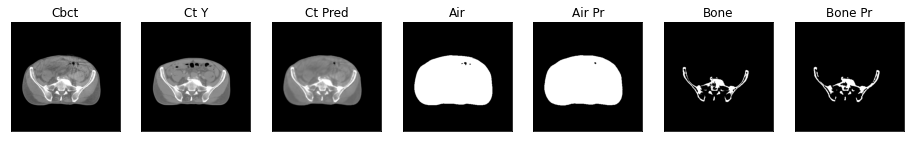

ssim score = 0.8824982643127441
psnr score = 23.13730239868164
snr score = 12.532770156860352
mae error = 0.0210974533110857
air dice score = 0.9971347412621994
bone dice score = 0.9081509184918254


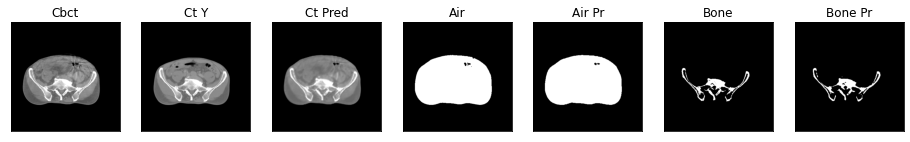

ssim score = 0.8813148140907288
psnr score = 22.917247772216797
snr score = 12.271605491638184
mae error = 0.021676329895853996
air dice score = 0.9965488247179491
bone dice score = 0.9073428420506355


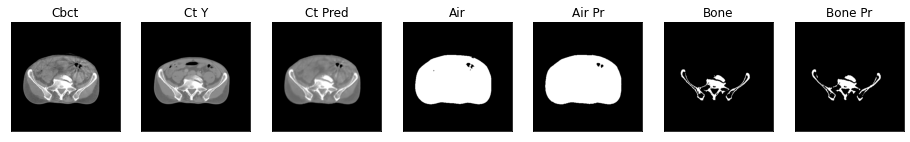

ssim score = 0.8681495785713196
psnr score = 23.78033447265625
snr score = 15.152491569519043
mae error = 0.024584433063864708
air dice score = 0.9977951418167296
bone dice score = 0.9729729729738323


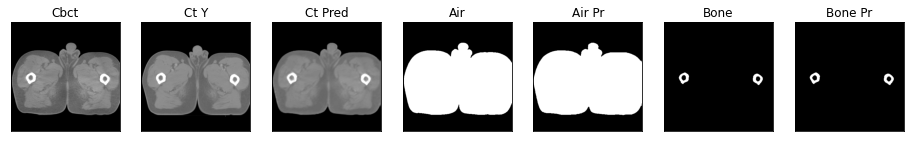

ssim score = 0.8740275502204895
psnr score = 24.335094451904297
snr score = 15.74650764465332
mae error = 0.023358646780252457
air dice score = 0.9979501724703841
bone dice score = 0.96691505216194


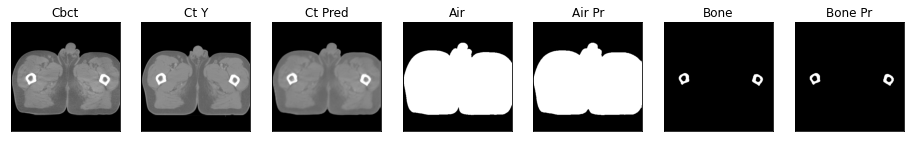

ssim score = 0.8803598284721375
psnr score = 24.798433303833008
snr score = 16.29729652404785
mae error = 0.022721167653799057
air dice score = 0.9981856983831201
bone dice score = 0.9634489222126652


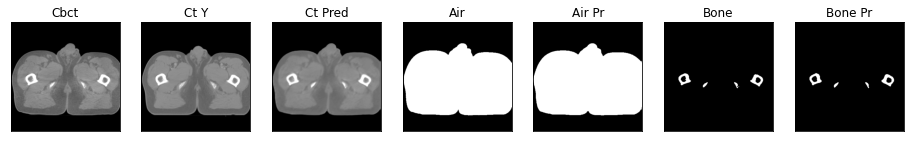

ssim score = 0.8838846683502197
psnr score = 25.12668800354004
snr score = 16.788108825683594
mae error = 0.02247585728764534
air dice score = 0.9982885504021917
bone dice score = 0.9604863221890819


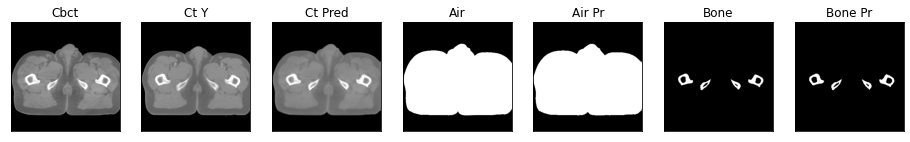

4it [00:09,  2.43s/it]

ssim score = 0.8839912414550781
psnr score = 25.354263305664062
snr score = 17.143827438354492
mae error = 0.022111229598522186
air dice score = 0.9981138274699745
bone dice score = 0.9408846630847336


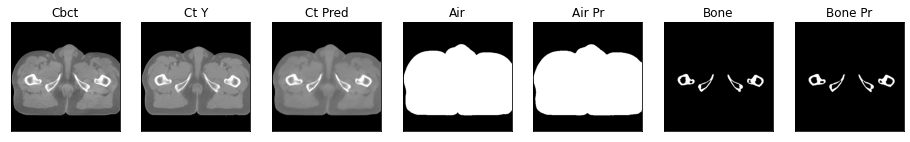

ssim score = 0.8858437538146973
psnr score = 25.818031311035156
snr score = 17.710830688476562
mae error = 0.021394090726971626
air dice score = 0.9982308820143722
bone dice score = 0.934709553529348


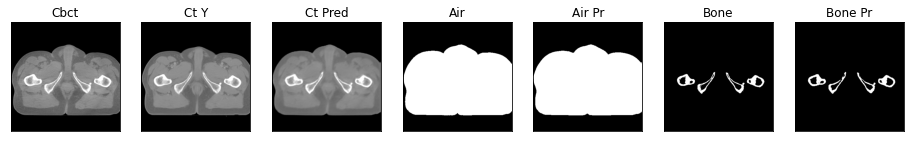

ssim score = 0.8866876363754272
psnr score = 26.121807098388672
snr score = 18.081708908081055
mae error = 0.02146066166460514
air dice score = 0.9982068141063968
bone dice score = 0.935073481027253


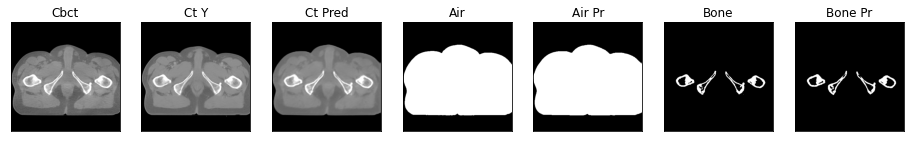

ssim score = 0.8853854537010193
psnr score = 26.13623046875
snr score = 18.086244583129883
mae error = 0.02146202139556408
air dice score = 0.9979539272560973
bone dice score = 0.9458536080345186


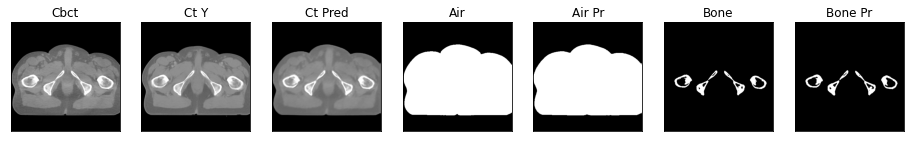

ssim score = 0.8889309763908386
psnr score = 26.258018493652344
snr score = 18.194368362426758
mae error = 0.021074289456009865
air dice score = 0.9981317842961764
bone dice score = 0.9525764730039769


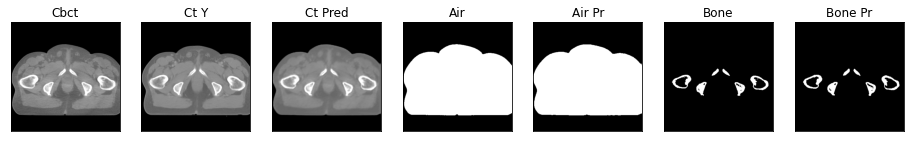

ssim score = 0.8901845216751099
psnr score = 26.407787322998047
snr score = 18.356138229370117
mae error = 0.020989878103137016
air dice score = 0.9979546667786314
bone dice score = 0.9512513601746327


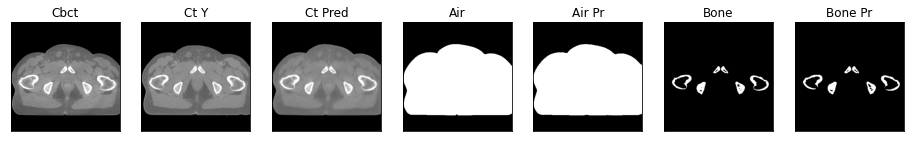

ssim score = 0.8891022801399231
psnr score = 26.36676025390625
snr score = 18.35419464111328
mae error = 0.020948093384504318
air dice score = 0.9980519675128132
bone dice score = 0.9447102013578295


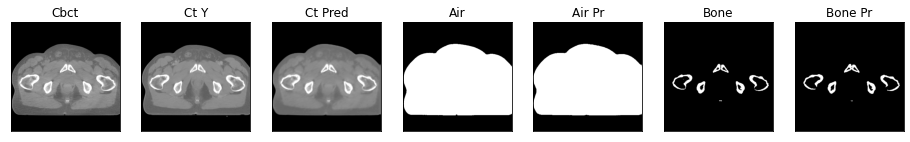

ssim score = 0.8869977593421936
psnr score = 26.361175537109375
snr score = 18.489900588989258
mae error = 0.0211783479899168
air dice score = 0.9979140692433119
bone dice score = 0.9420001892332104


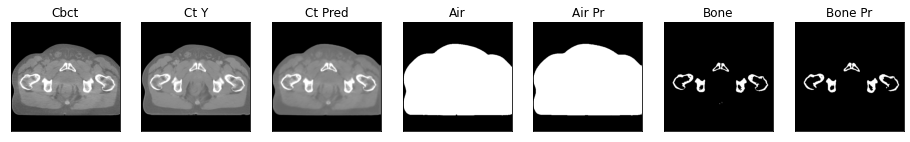

5it [00:11,  2.33s/it]

ssim score = 0.8862169981002808
psnr score = 26.40691566467285
snr score = 18.630325317382812
mae error = 0.021542886272072792
air dice score = 0.9978753286038401
bone dice score = 0.9474176938684084


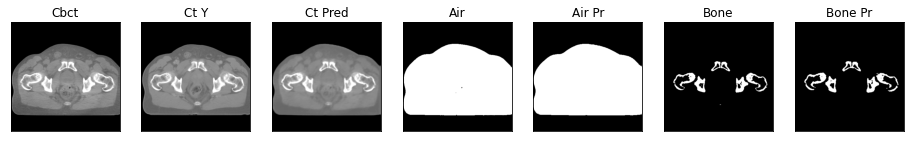

ssim score = 0.8751564621925354
psnr score = 25.89681625366211
snr score = 18.086181640625
mae error = 0.023288961499929428
air dice score = 0.9972050213237614
bone dice score = 0.9272478736336023


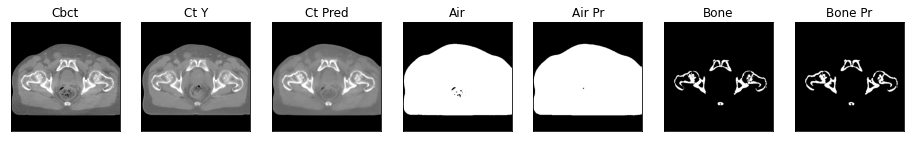

ssim score = 0.8724316358566284
psnr score = 25.365619659423828
snr score = 17.62717056274414
mae error = 0.023989219218492508
air dice score = 0.9967918978744069
bone dice score = 0.9238395673731807


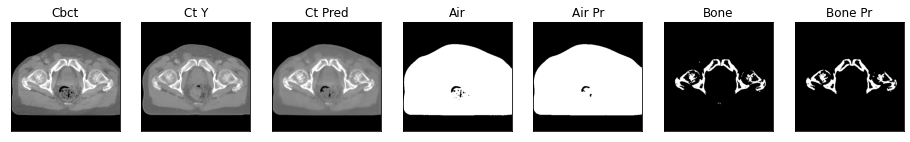

ssim score = 0.8716872334480286
psnr score = 25.45091438293457
snr score = 17.57636833190918
mae error = 0.02340284176170826
air dice score = 0.9972501399265098
bone dice score = 0.9087143803851166


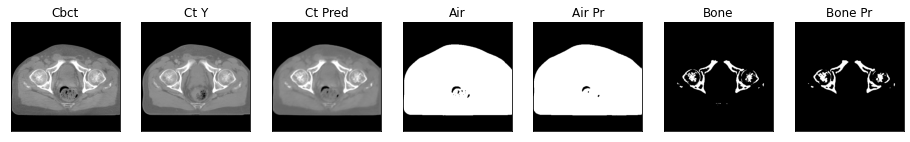

ssim score = 0.8768244981765747
psnr score = 25.24585723876953
snr score = 17.1927490234375
mae error = 0.023012829944491386
air dice score = 0.9973103359945369
bone dice score = 0.9038213033052998


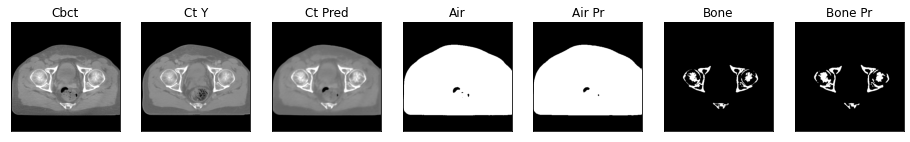

ssim score = 0.8768052458763123
psnr score = 25.383970260620117
snr score = 17.240276336669922
mae error = 0.022900434210896492
air dice score = 0.9976244129735158
bone dice score = 0.8922035332710018


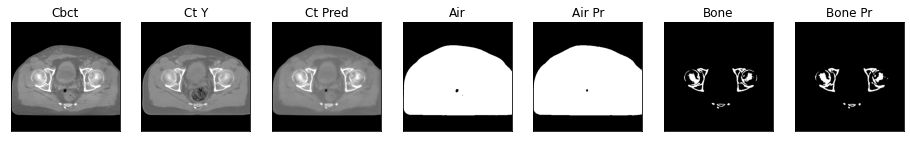

ssim score = 0.8762815594673157
psnr score = 25.300643920898438
snr score = 17.172639846801758
mae error = 0.02278394252061844
air dice score = 0.9980377969365116
bone dice score = 0.9106008793364866


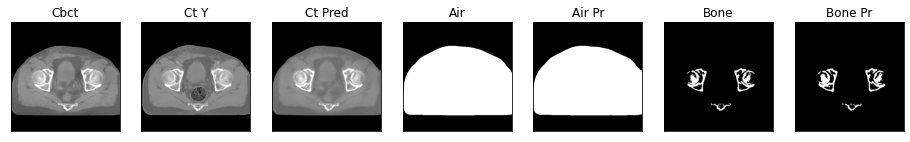

ssim score = 0.8666314482688904
psnr score = 25.130455017089844
snr score = 17.01248550415039
mae error = 0.023589447140693665
air dice score = 0.9979224334038198
bone dice score = 0.928552456839942


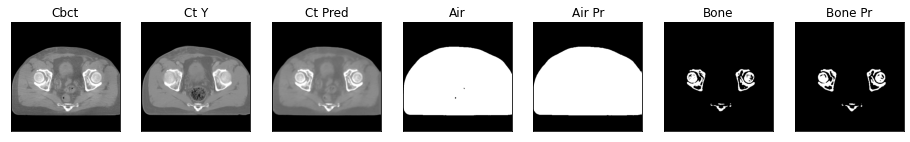

6it [00:13,  2.32s/it]

ssim score = 0.8752852082252502
psnr score = 25.693870544433594
snr score = 17.637493133544922
mae error = 0.02212008833885193
air dice score = 0.9979395476905003
bone dice score = 0.9455632749982802


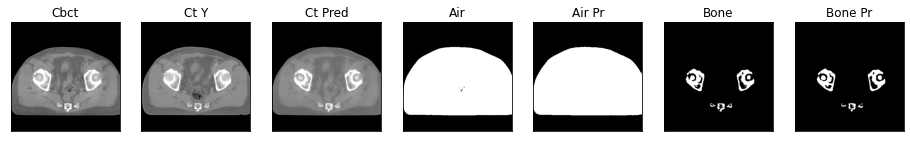

ssim score = 0.8789274096488953
psnr score = 26.28378677368164
snr score = 18.297489166259766
mae error = 0.0211796797811985
air dice score = 0.9977232261946873
bone dice score = 0.9640780020529929


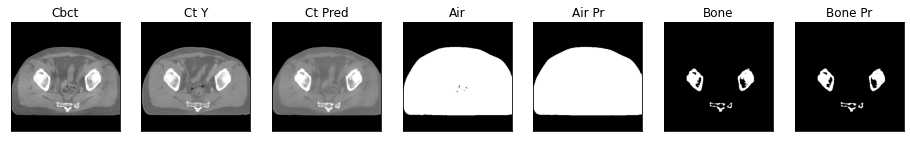

ssim score = 0.8800466060638428
psnr score = 25.69247817993164
snr score = 17.587072372436523
mae error = 0.02216571755707264
air dice score = 0.9977852086680866
bone dice score = 0.954653937947927


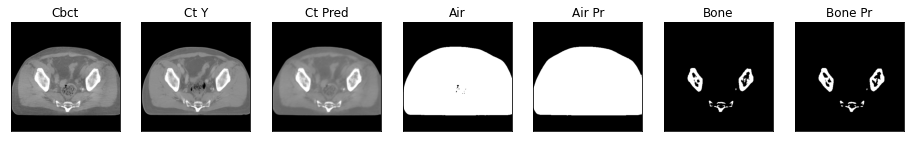

ssim score = 0.8724791407585144
psnr score = 25.105682373046875
snr score = 17.081905364990234
mae error = 0.02395481802523136
air dice score = 0.9973956395565162
bone dice score = 0.9529411764709836


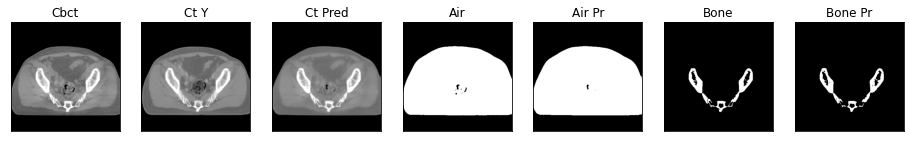

ssim score = 0.8725389838218689
psnr score = 25.13451385498047
snr score = 17.190885543823242
mae error = 0.023835211992263794
air dice score = 0.997384989093795
bone dice score = 0.9510992108233435


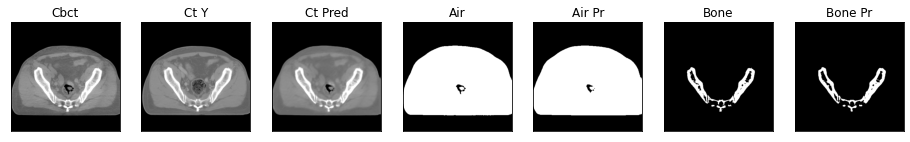

ssim score = 0.8601834774017334
psnr score = 24.709815979003906
snr score = 16.787744522094727
mae error = 0.02557366155087948
air dice score = 0.997997849542102
bone dice score = 0.9389345423637083


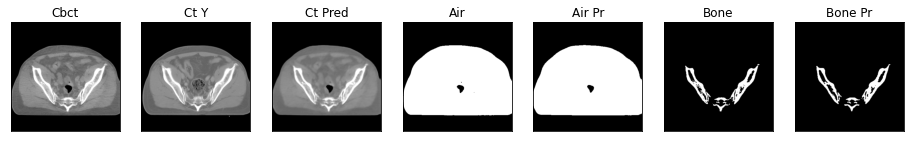

ssim score = 0.8604673743247986
psnr score = 25.129735946655273
snr score = 17.220203399658203
mae error = 0.025388415902853012
air dice score = 0.9976776533882378
bone dice score = 0.9452437191328806


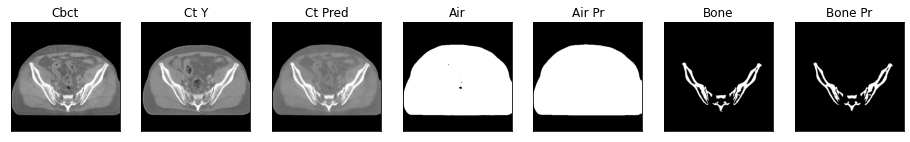

ssim score = 0.8174281716346741
psnr score = 21.02359390258789
snr score = 10.903800964355469
mae error = 0.032506585121154785
air dice score = 0.9809043182490564
bone dice score = 0.9491807831172124


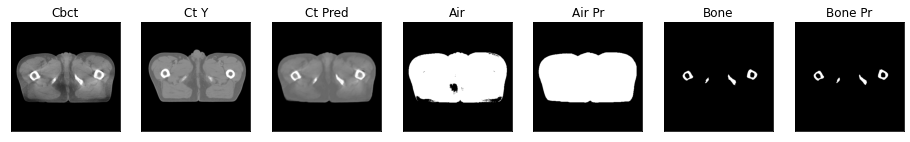

7it [00:16,  2.31s/it]

ssim score = 0.806060254573822
psnr score = 20.722970962524414
snr score = 10.816160202026367
mae error = 0.03465026244521141
air dice score = 0.981353781651697
bone dice score = 0.9215425531932282


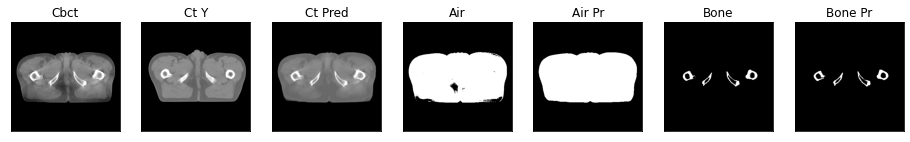

ssim score = 0.8011592626571655
psnr score = 20.75897216796875
snr score = 10.983299255371094
mae error = 0.03497882932424545
air dice score = 0.9822818620052667
bone dice score = 0.9005524861899585


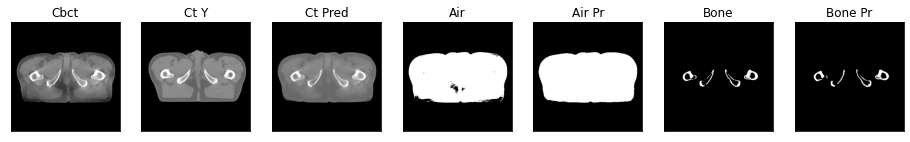

ssim score = 0.8047267198562622
psnr score = 21.078575134277344
snr score = 11.373302459716797
mae error = 0.03381895646452904
air dice score = 0.9802028182408579
bone dice score = 0.9039775010063483


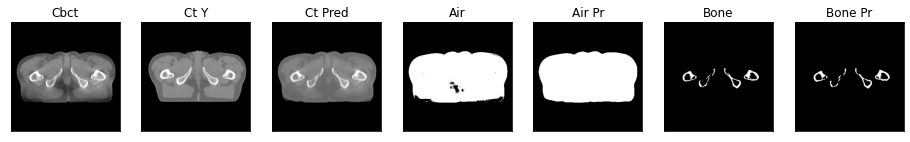

ssim score = 0.8049606680870056
psnr score = 21.102697372436523
snr score = 11.44499397277832
mae error = 0.03384682908654213
air dice score = 0.9816740328974515
bone dice score = 0.9008085190317332


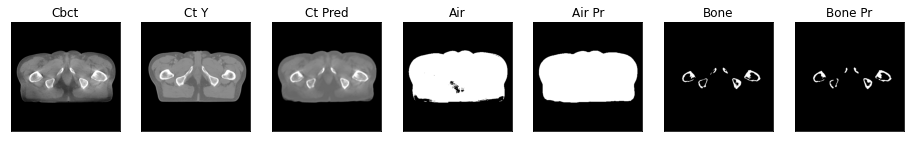

ssim score = 0.807762622833252
psnr score = 21.301300048828125
snr score = 11.649212837219238
mae error = 0.03310840204358101
air dice score = 0.982769901853887
bone dice score = 0.8926726611843758


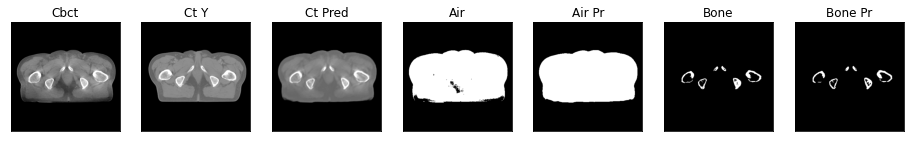

ssim score = 0.8112029433250427
psnr score = 21.413631439208984
snr score = 11.755041122436523
mae error = 0.03254598379135132
air dice score = 0.9832671197545875
bone dice score = 0.9100000000017308


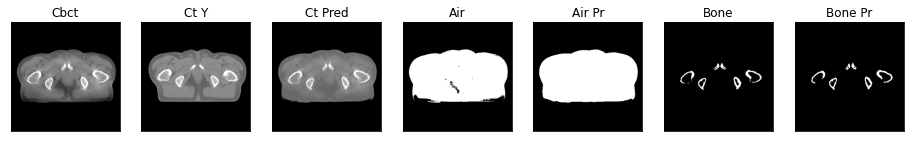

ssim score = 0.8105646371841431
psnr score = 21.278047561645508
snr score = 11.633563995361328
mae error = 0.032892078161239624
air dice score = 0.9852021769441954
bone dice score = 0.9151785714301492


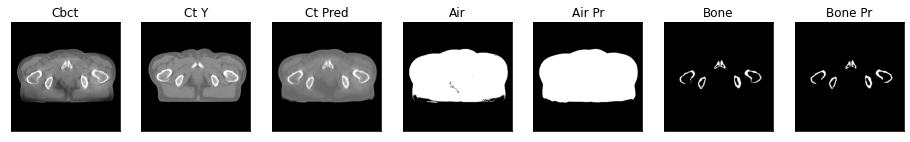

ssim score = 0.8094003200531006
psnr score = 21.212242126464844
snr score = 11.625767707824707
mae error = 0.033521540462970734
air dice score = 0.9857071123704443
bone dice score = 0.9036742800413162


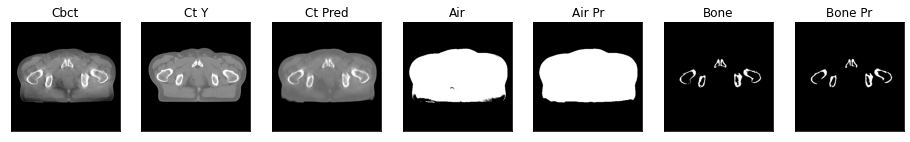

8it [00:18,  2.24s/it]

ssim score = 0.7997686266899109
psnr score = 21.03490447998047
snr score = 11.546991348266602
mae error = 0.035156507045030594
air dice score = 0.9857215751922568
bone dice score = 0.8801128349807222


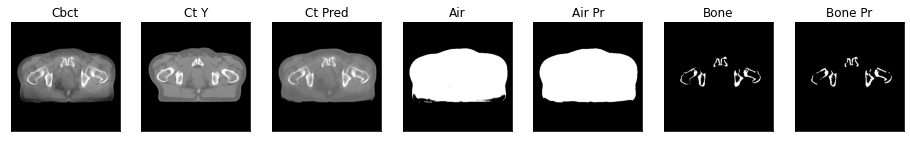

ssim score = 0.788564145565033
psnr score = 20.871746063232422
snr score = 11.419660568237305
mae error = 0.03628508746623993
air dice score = 0.9852845259687595
bone dice score = 0.8831782602291659


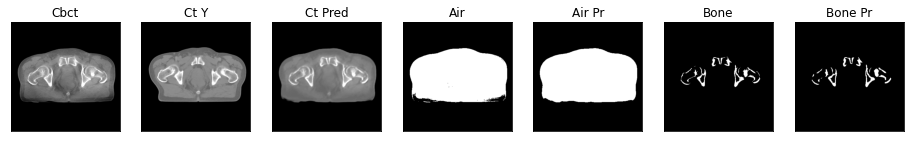

ssim score = 0.7775624394416809
psnr score = 20.727195739746094
snr score = 11.307817459106445
mae error = 0.03663209453225136
air dice score = 0.9848648359391161
bone dice score = 0.847962382447127


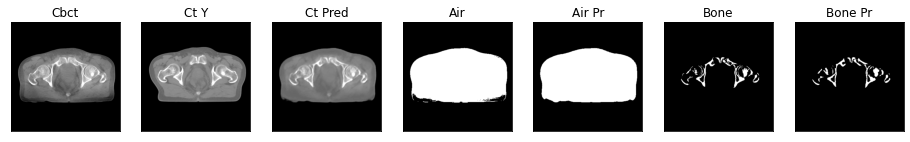

ssim score = 0.7801791429519653
psnr score = 20.802936553955078
snr score = 11.500373840332031
mae error = 0.03694188594818115
air dice score = 0.9846940593706704
bone dice score = 0.8761880297986618


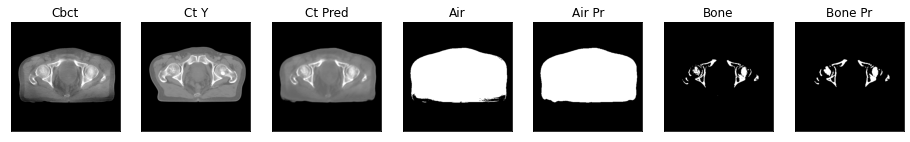

ssim score = 0.7848124504089355
psnr score = 20.770553588867188
snr score = 11.452006340026855
mae error = 0.03697066381573677
air dice score = 0.9838354871173874
bone dice score = 0.8679354932461436


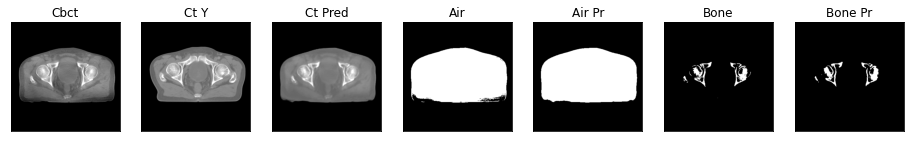

ssim score = 0.8004820942878723
psnr score = 21.336156845092773
snr score = 11.818445205688477
mae error = 0.033411845564842224
air dice score = 0.9829199042304319
bone dice score = 0.8978570311293937


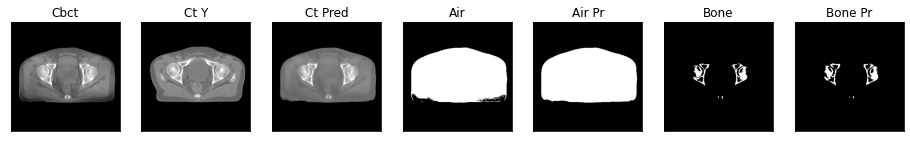

ssim score = 0.817479133605957
psnr score = 22.04277992248535
snr score = 12.35467529296875
mae error = 0.030262449756264687
air dice score = 0.9825796359499586
bone dice score = 0.9242982704859045


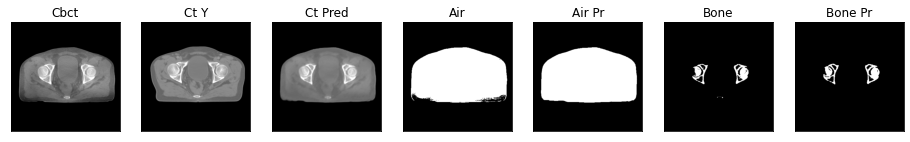

ssim score = 0.8239302039146423
psnr score = 22.358379364013672
snr score = 12.684444427490234
mae error = 0.02938605099916458
air dice score = 0.9817367424747543
bone dice score = 0.9371993586325869


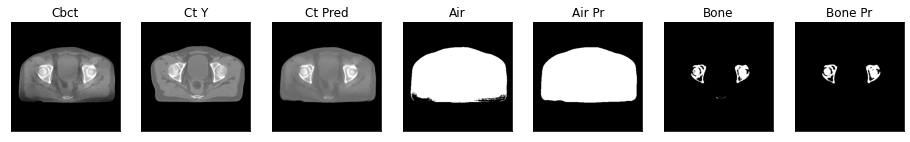

9it [00:20,  2.25s/it]

ssim score = 0.8280305862426758
psnr score = 22.596370697021484
snr score = 13.004264831542969
mae error = 0.028977708891034126
air dice score = 0.9814627210521804
bone dice score = 0.9430542404985385


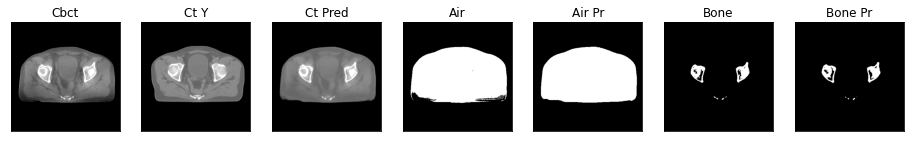

ssim score = 0.826714038848877
psnr score = 22.526025772094727
snr score = 13.026092529296875
mae error = 0.029408419504761696
air dice score = 0.9800871796237781
bone dice score = 0.9259088817314632


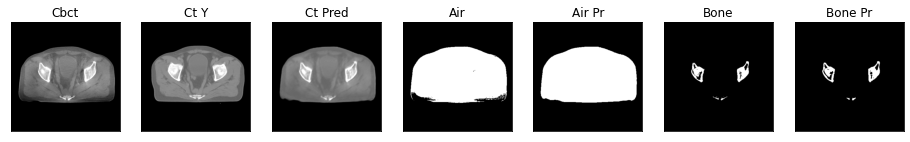

ssim score = 0.8268818855285645
psnr score = 22.845176696777344
snr score = 13.281814575195312
mae error = 0.02842695824801922
air dice score = 0.9811732990335734
bone dice score = 0.9472620050556485


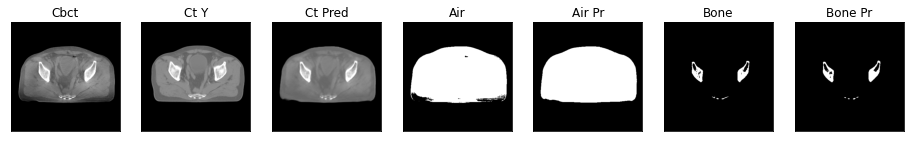

ssim score = 0.8309752941131592
psnr score = 23.089527130126953
snr score = 13.48977279663086
mae error = 0.027350695803761482
air dice score = 0.9816738257869325
bone dice score = 0.9406175771982347


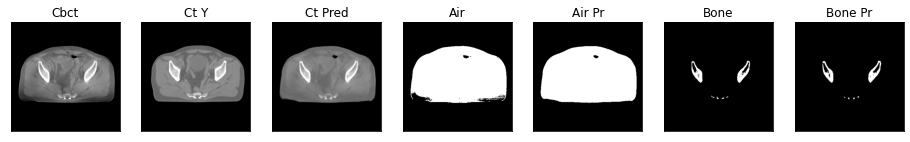

ssim score = 0.8268436193466187
psnr score = 22.859106063842773
snr score = 13.297098159790039
mae error = 0.028684908524155617
air dice score = 0.9818987030333012
bone dice score = 0.9086874893342092


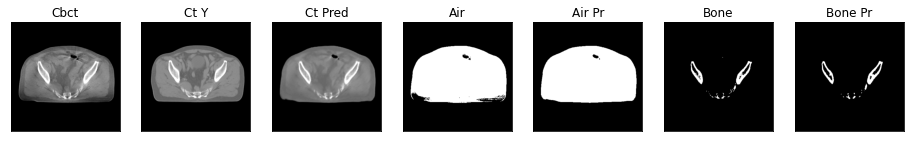

ssim score = 0.8216909170150757
psnr score = 22.762802124023438
snr score = 13.331297874450684
mae error = 0.029405511915683746
air dice score = 0.9820952113467367
bone dice score = 0.9059575100296248


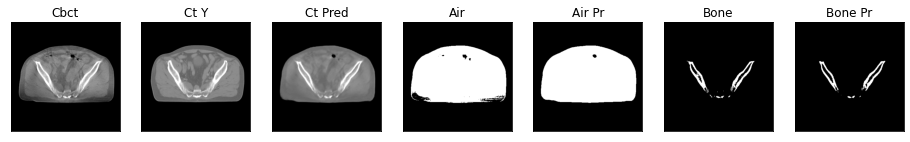

ssim score = 0.8215107321739197
psnr score = 22.692607879638672
snr score = 13.278852462768555
mae error = 0.02959400787949562
air dice score = 0.9831379589537939
bone dice score = 0.8770465489586349


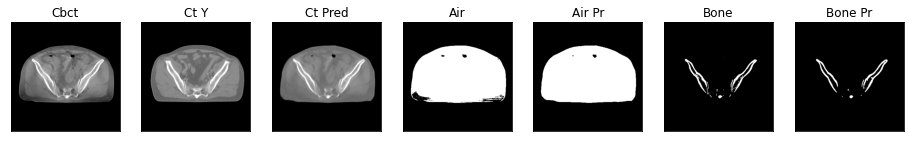

ssim score = 0.823036789894104
psnr score = 23.14203453063965
snr score = 13.717011451721191
mae error = 0.02856197953224182
air dice score = 0.983671379900807
bone dice score = 0.895090439278293


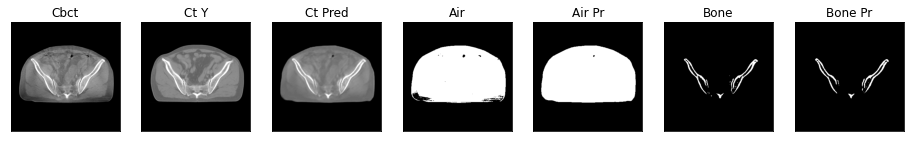

10it [00:22,  2.19s/it]

ssim score = 0.8256556987762451
psnr score = 23.253337860107422
snr score = 13.827571868896484
mae error = 0.028089476749300957
air dice score = 0.9837798594018524
bone dice score = 0.8803875710009958


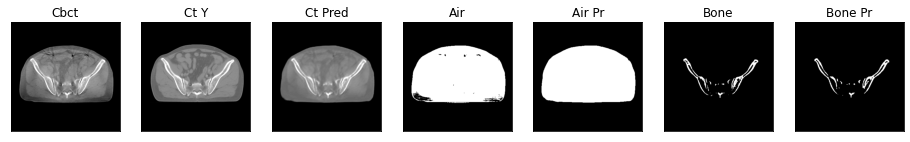

ssim score = 0.8761795163154602
psnr score = 24.71540641784668
snr score = 15.149543762207031
mae error = 0.020920077338814735
air dice score = 0.9980659822392718
bone dice score = 0.9401313248381564


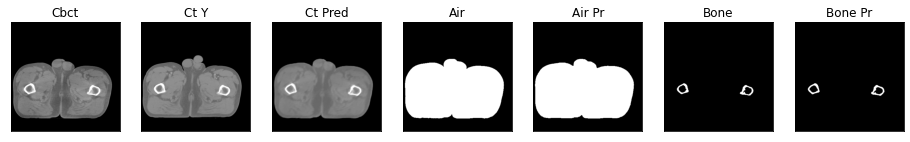

ssim score = 0.8752762675285339
psnr score = 24.910892486572266
snr score = 15.40942096710205
mae error = 0.02068505622446537
air dice score = 0.997634834478503
bone dice score = 0.9234042553218651


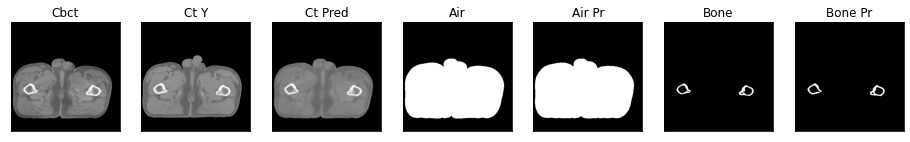

ssim score = 0.8802241683006287
psnr score = 26.533794403076172
snr score = 17.171533584594727
mae error = 0.019510874524712563
air dice score = 0.997423967407245
bone dice score = 0.9232179692889475


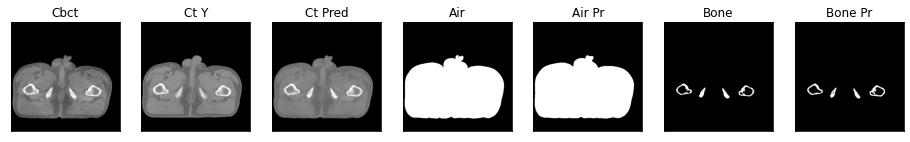

ssim score = 0.8812699317932129
psnr score = 26.38767433166504
snr score = 17.14690589904785
mae error = 0.019859353080391884
air dice score = 0.9972809167645296
bone dice score = 0.9182035148640008


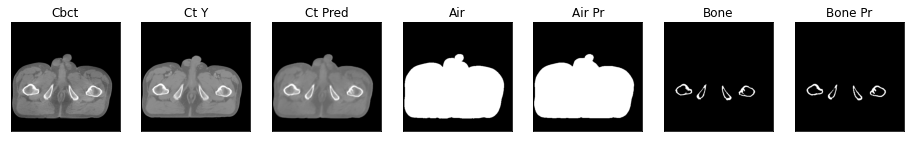

ssim score = 0.8760862946510315
psnr score = 26.052331924438477
snr score = 16.835735321044922
mae error = 0.0202187467366457
air dice score = 0.9972798742138386
bone dice score = 0.8901811675265001


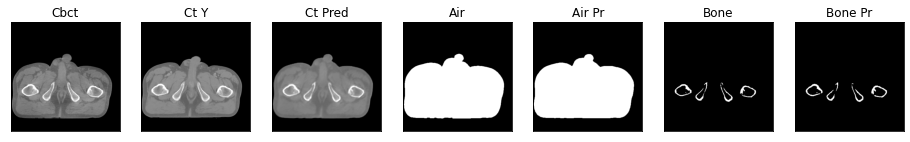

ssim score = 0.8775710463523865
psnr score = 25.89195442199707
snr score = 16.670963287353516
mae error = 0.02014853060245514
air dice score = 0.9971034515240264
bone dice score = 0.8934862761185275


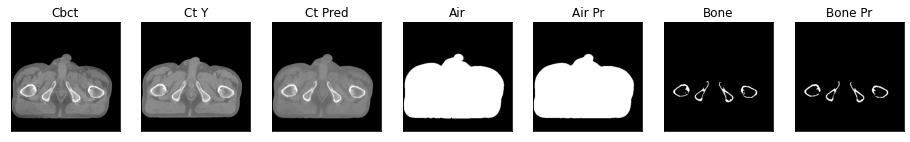

ssim score = 0.8781514167785645
psnr score = 25.342735290527344
snr score = 16.12799835205078
mae error = 0.020961854606866837
air dice score = 0.996988188050011
bone dice score = 0.8987012987033226


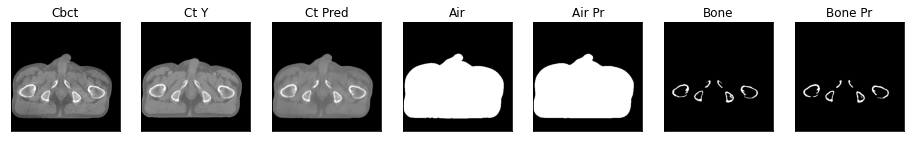

11it [00:24,  2.22s/it]

ssim score = 0.8759931325912476
psnr score = 25.040138244628906
snr score = 15.80384349822998
mae error = 0.02097734436392784
air dice score = 0.9972518844221127
bone dice score = 0.8999403222617876


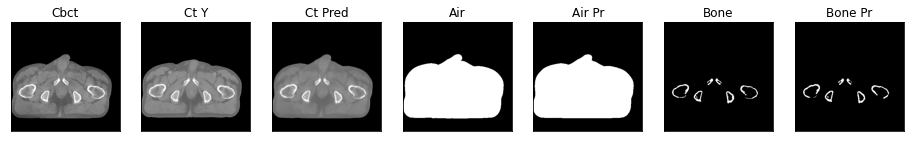

ssim score = 0.8764157295227051
psnr score = 25.042116165161133
snr score = 15.822732925415039
mae error = 0.021047959104180336
air dice score = 0.997542804038624
bone dice score = 0.9155820007453406


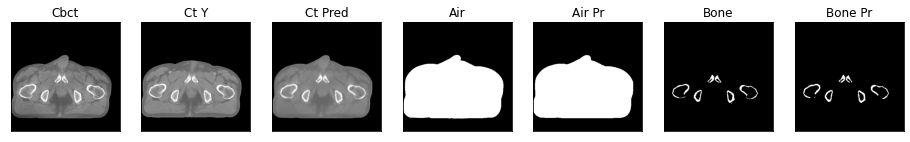

ssim score = 0.8778537511825562
psnr score = 25.41791534423828
snr score = 16.26712417602539
mae error = 0.020543767139315605
air dice score = 0.9979931102051152
bone dice score = 0.9045020463863489


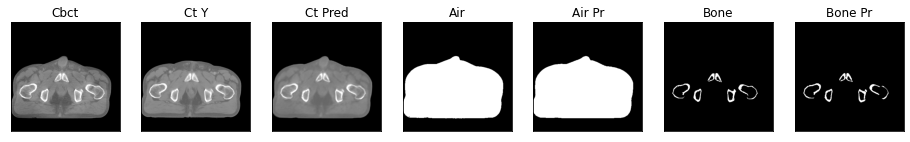

ssim score = 0.877765417098999
psnr score = 25.840131759643555
snr score = 16.77069854736328
mae error = 0.020066211000084877
air dice score = 0.9983102882029572
bone dice score = 0.9057068143377064


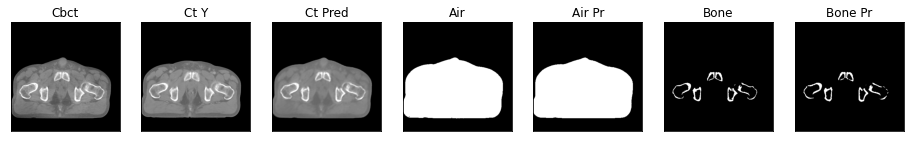

ssim score = 0.879740297794342
psnr score = 26.282880783081055
snr score = 17.26415252685547
mae error = 0.019613632932305336
air dice score = 0.9980010989973656
bone dice score = 0.8845817545921804


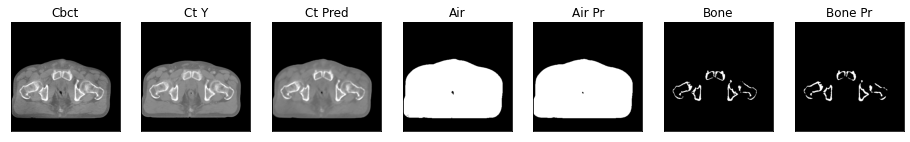

ssim score = 0.8808256387710571
psnr score = 26.744661331176758
snr score = 17.842199325561523
mae error = 0.01936201937496662
air dice score = 0.9980831283345595
bone dice score = 0.8678634093687696


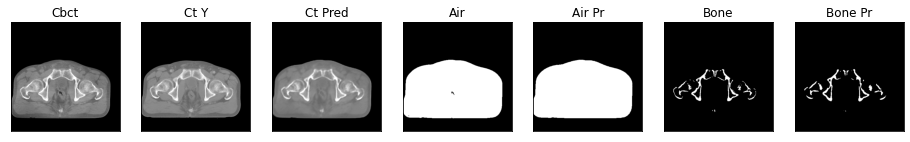

ssim score = 0.8798739910125732
psnr score = 26.484296798706055
snr score = 17.54360008239746
mae error = 0.01945463754236698
air dice score = 0.9975164165668698
bone dice score = 0.8534433693817097


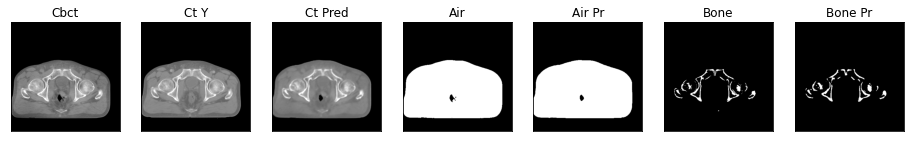

ssim score = 0.8748054504394531
psnr score = 25.7155818939209
snr score = 16.679214477539062
mae error = 0.02037019282579422
air dice score = 0.9971836930144247
bone dice score = 0.8545124481346665


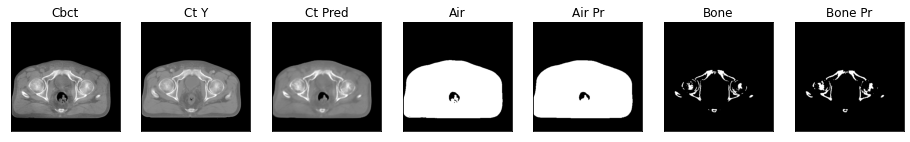

12it [00:26,  2.18s/it]

ssim score = 0.8793919086456299
psnr score = 25.575092315673828
snr score = 16.378965377807617
mae error = 0.020190034061670303
air dice score = 0.9970903146710282
bone dice score = 0.85005710556616


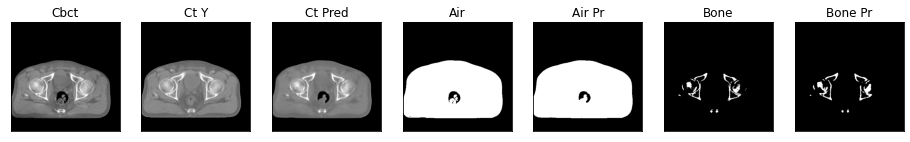

ssim score = 0.8787259459495544
psnr score = 25.127796173095703
snr score = 15.815247535705566
mae error = 0.020405123010277748
air dice score = 0.997447019457184
bone dice score = 0.8566133108701497


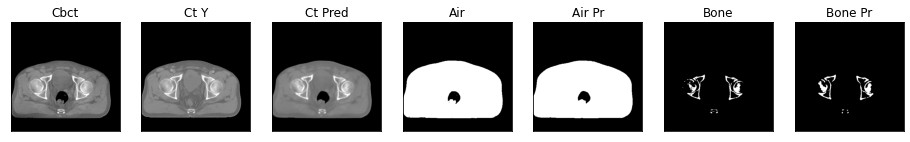

ssim score = 0.875256359577179
psnr score = 25.025726318359375
snr score = 15.668081283569336
mae error = 0.020531008020043373
air dice score = 0.9972649203169057
bone dice score = 0.8938248267187489


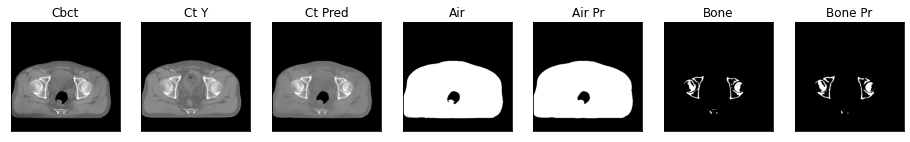

ssim score = 0.8688753247261047
psnr score = 24.30925178527832
snr score = 14.958281517028809
mae error = 0.022209711372852325
air dice score = 0.9970333827769562
bone dice score = 0.9117139720885727


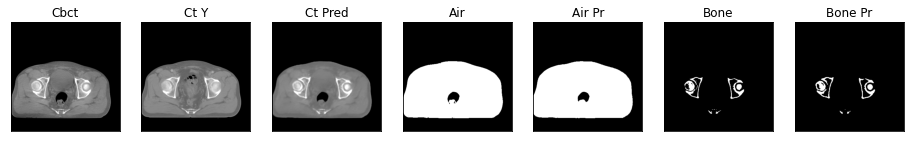

ssim score = 0.8719237446784973
psnr score = 24.00221061706543
snr score = 14.681343078613281
mae error = 0.0228897575289011
air dice score = 0.997203696129417
bone dice score = 0.934426229509174


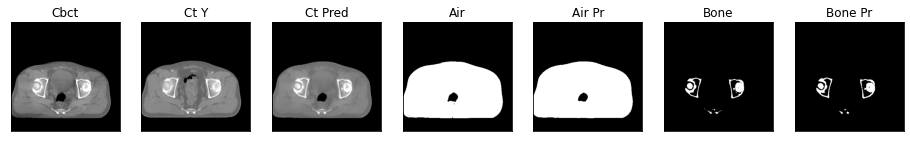

ssim score = 0.8783591389656067
psnr score = 24.647157669067383
snr score = 15.28370475769043
mae error = 0.021632084622979164
air dice score = 0.9971312295683525
bone dice score = 0.9239980043252287


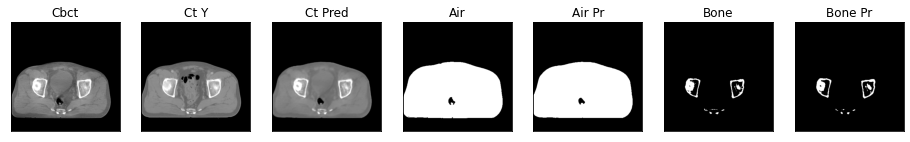

ssim score = 0.8812302350997925
psnr score = 25.017431259155273
snr score = 15.563770294189453
mae error = 0.020126456394791603
air dice score = 0.9971645323987745
bone dice score = 0.916556790357571


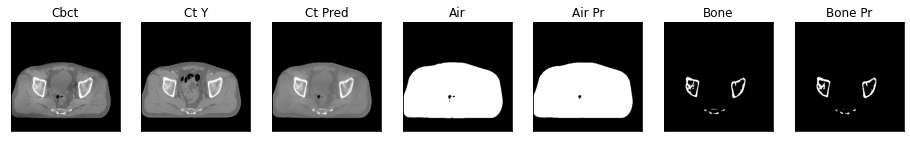

ssim score = 0.8819700479507446
psnr score = 24.637754440307617
snr score = 15.118369102478027
mae error = 0.020571332424879074
air dice score = 0.9977200952493559
bone dice score = 0.9280760848042783


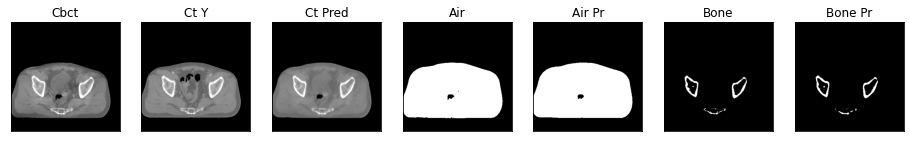

13it [00:29,  2.21s/it]

ssim score = 0.8795552849769592
psnr score = 24.655197143554688
snr score = 15.135509490966797
mae error = 0.02063889056444168
air dice score = 0.9966676041693329
bone dice score = 0.9304347826099055


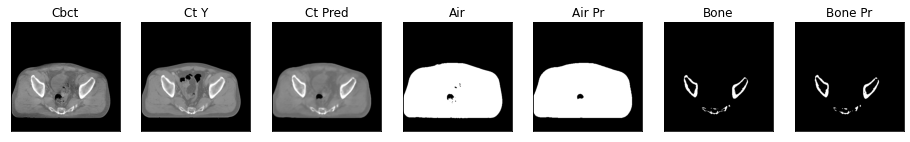

ssim score = 0.8739021420478821
psnr score = 24.53594970703125
snr score = 15.092429161071777
mae error = 0.021631203591823578
air dice score = 0.9966615614943843
bone dice score = 0.9230552423911632


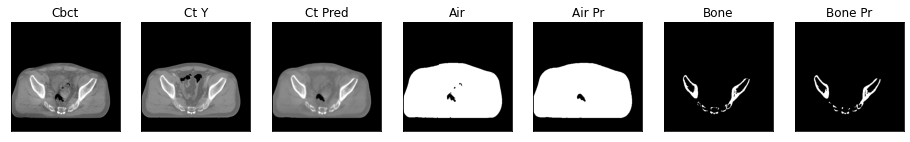

ssim score = 0.8788864612579346
psnr score = 24.731786727905273
snr score = 15.323847770690918
mae error = 0.02110506035387516
air dice score = 0.9955251838490395
bone dice score = 0.9050353946853875


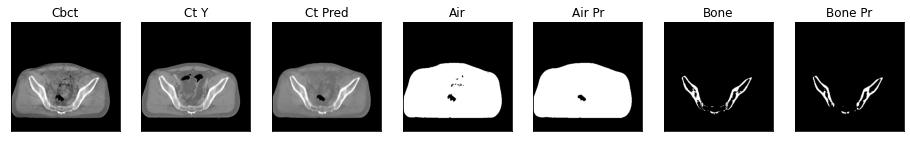

ssim score = 0.881386935710907
psnr score = 25.460912704467773
snr score = 15.991276741027832
mae error = 0.019772790372371674
air dice score = 0.9955557104763272
bone dice score = 0.877807599945221


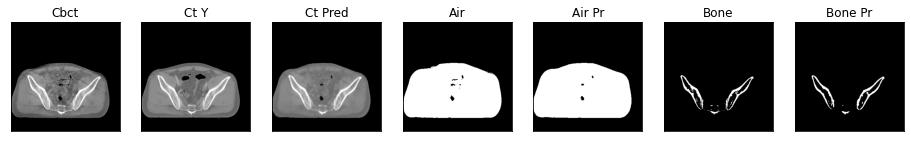

ssim score = 0.8773995637893677
psnr score = 25.075294494628906
snr score = 15.54439640045166
mae error = 0.020466554909944534
air dice score = 0.99439729099785
bone dice score = 0.8824391674013128


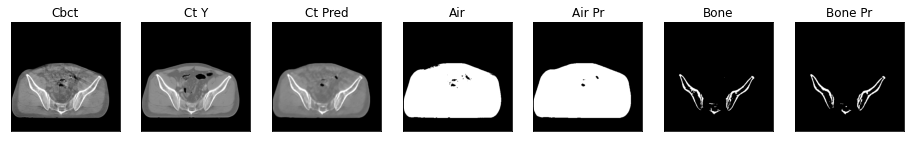

ssim score = 0.8147339820861816
psnr score = 22.340065002441406
snr score = 14.037369728088379
mae error = 0.032024186104536057
air dice score = 0.9981233788742675
bone dice score = 0.9583730537032611


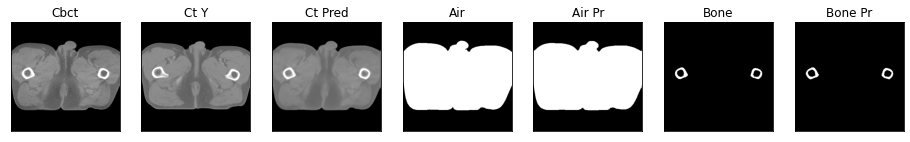

ssim score = 0.8069970011711121
psnr score = 22.022083282470703
snr score = 13.823678970336914
mae error = 0.03311658278107643
air dice score = 0.9980695554037611
bone dice score = 0.954049396899654


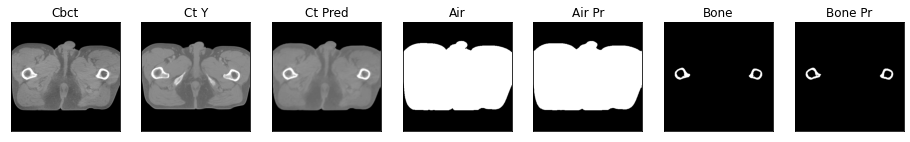

ssim score = 0.8014175295829773
psnr score = 21.75569725036621
snr score = 13.685250282287598
mae error = 0.034583378583192825
air dice score = 0.9982183550859758
bone dice score = 0.9342528735647299


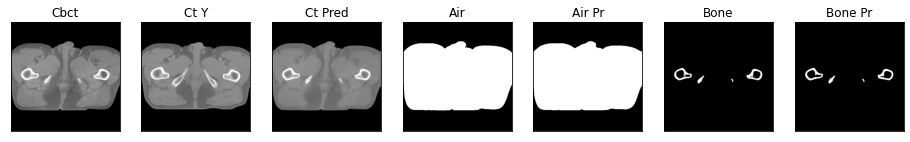

14it [00:31,  2.23s/it]

ssim score = 0.7927514910697937
psnr score = 21.366981506347656
snr score = 13.328824996948242
mae error = 0.035716164857149124
air dice score = 0.9978869581641339
bone dice score = 0.9356783919608764


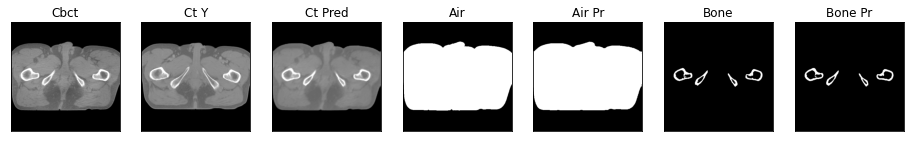

ssim score = 0.7818215489387512
psnr score = 21.23114013671875
snr score = 13.223220825195312
mae error = 0.03666815161705017
air dice score = 0.9978455380268437
bone dice score = 0.9099967856009322


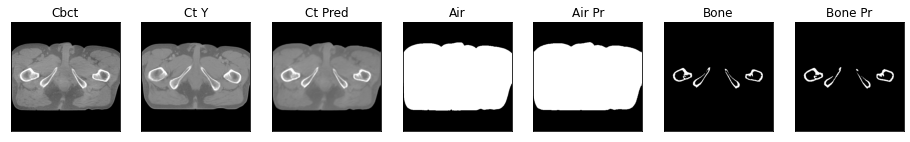

ssim score = 0.7752642035484314
psnr score = 21.166934967041016
snr score = 13.193431854248047
mae error = 0.03752093017101288
air dice score = 0.9976885801781098
bone dice score = 0.9103132161969394


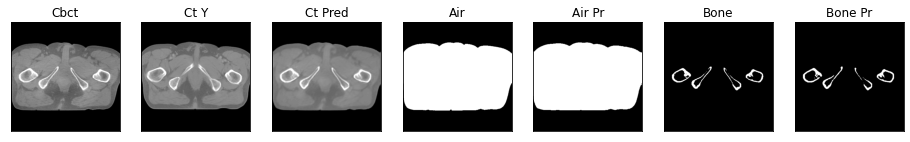

ssim score = 0.7674316763877869
psnr score = 20.866405487060547
snr score = 12.913213729858398
mae error = 0.0389719121158123
air dice score = 0.9978536882058132
bone dice score = 0.9210065939991791


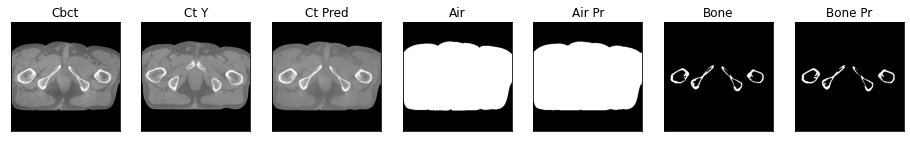

ssim score = 0.7658392190933228
psnr score = 20.88505744934082
snr score = 12.970941543579102
mae error = 0.038487568497657776
air dice score = 0.9979904429204017
bone dice score = 0.9219952241984347


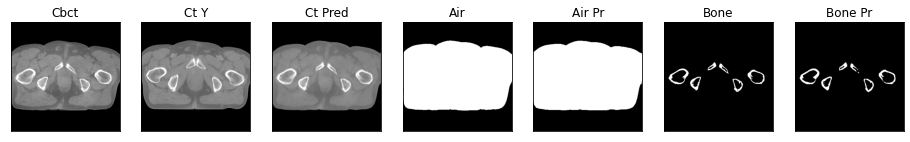

ssim score = 0.7650159001350403
psnr score = 20.982675552368164
snr score = 13.117237091064453
mae error = 0.03813167288899422
air dice score = 0.9980717090501133
bone dice score = 0.9295556986486857


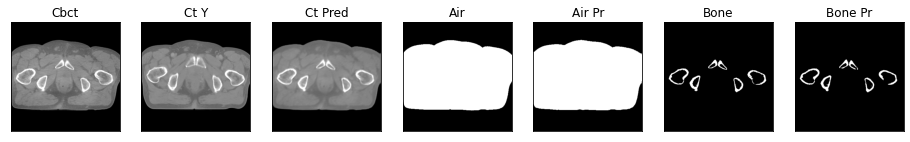

ssim score = 0.7578418850898743
psnr score = 20.826461791992188
snr score = 12.983633041381836
mae error = 0.039735496044158936
air dice score = 0.9983298294790947
bone dice score = 0.9299284480640275


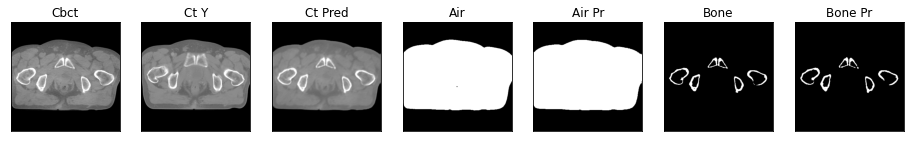

ssim score = 0.7466133832931519
psnr score = 20.78034210205078
snr score = 12.980291366577148
mae error = 0.04113366827368736
air dice score = 0.9983753850453911
bone dice score = 0.9223189734197716


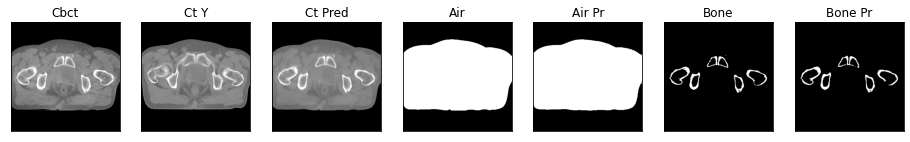

15it [00:33,  2.20s/it]

ssim score = 0.7455267906188965
psnr score = 20.729461669921875
snr score = 12.987751007080078
mae error = 0.04188305139541626
air dice score = 0.9984439231716107
bone dice score = 0.9181980468348399


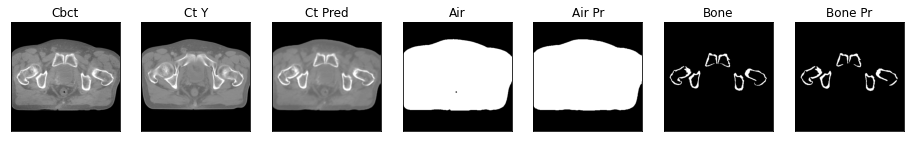

ssim score = 0.7379348874092102
psnr score = 20.42630958557129
snr score = 12.609228134155273
mae error = 0.044112060219049454
air dice score = 0.9982550218846933
bone dice score = 0.9100817438700547


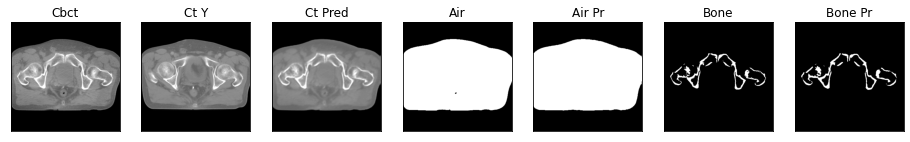

ssim score = 0.7419602274894714
psnr score = 20.28883171081543
snr score = 12.364531517028809
mae error = 0.04470910131931305
air dice score = 0.9984985246120232
bone dice score = 0.8969016126119143


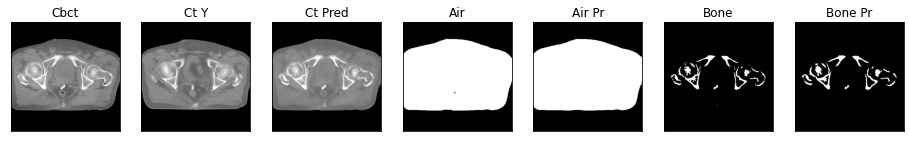

ssim score = 0.7563349604606628
psnr score = 20.55728530883789
snr score = 12.509897232055664
mae error = 0.04394763708114624
air dice score = 0.9985610174998848
bone dice score = 0.8952180028138607


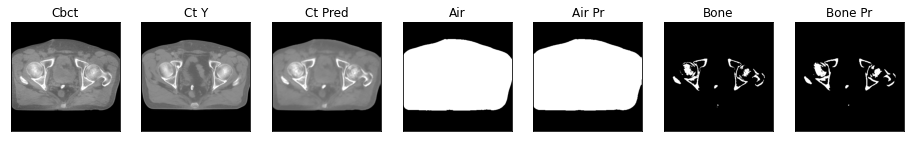

ssim score = 0.7620624303817749
psnr score = 20.773237228393555
snr score = 12.613419532775879
mae error = 0.042679209262132645
air dice score = 0.998470174214002
bone dice score = 0.9132619205620128


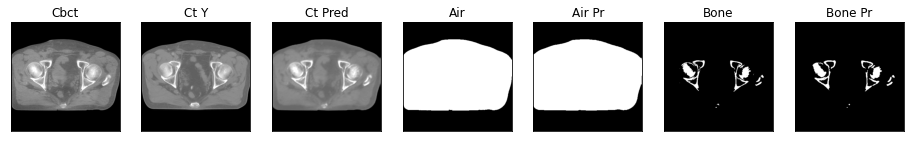

ssim score = 0.7593996524810791
psnr score = 21.008544921875
snr score = 12.798078536987305
mae error = 0.04057672992348671
air dice score = 0.9982560818416719
bone dice score = 0.9196009389679225


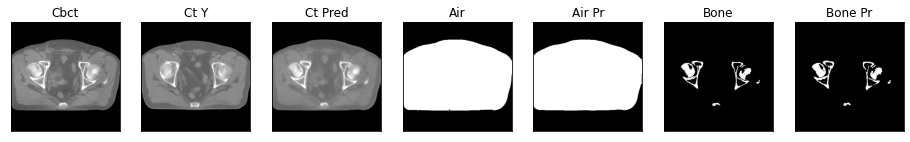

ssim score = 0.7567918300628662
psnr score = 20.879629135131836
snr score = 12.701318740844727
mae error = 0.04127700999379158
air dice score = 0.9981976499227575
bone dice score = 0.9141830479823062


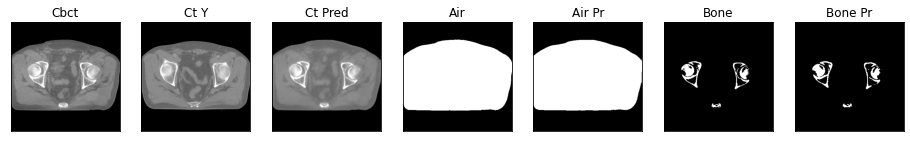

ssim score = 0.7559368014335632
psnr score = 20.69147491455078
snr score = 12.526640892028809
mae error = 0.04193310812115669
air dice score = 0.9985310535284103
bone dice score = 0.9257861635228611


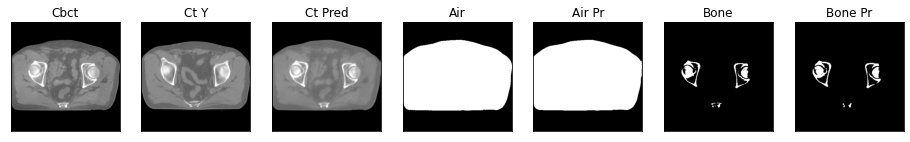

16it [00:35,  2.23s/it]

ssim score = 0.754801332950592
psnr score = 20.206981658935547
snr score = 11.900653839111328
mae error = 0.04423466697335243
air dice score = 0.9981274403823105
bone dice score = 0.9343031982457648


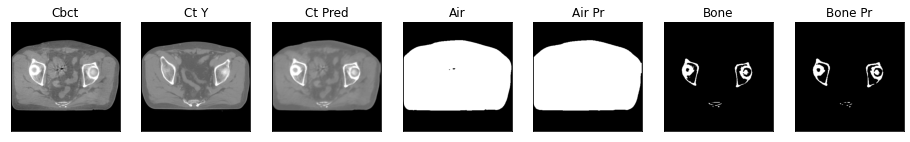

ssim score = 0.7635995149612427
psnr score = 20.288711547851562
snr score = 11.923075675964355
mae error = 0.04350464418530464
air dice score = 0.9988002185740427
bone dice score = 0.9346413893684921


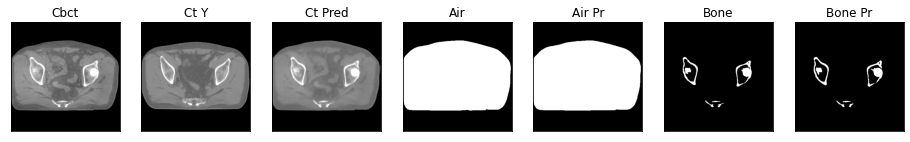

ssim score = 0.762438178062439
psnr score = 20.713977813720703
snr score = 12.373991012573242
mae error = 0.04053298756480217
air dice score = 0.9987283961672794
bone dice score = 0.9027726432550319


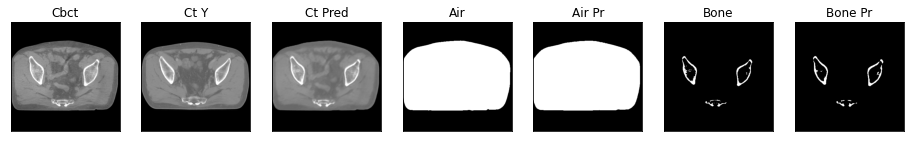

ssim score = 0.7592072486877441
psnr score = 20.67584228515625
snr score = 12.408670425415039
mae error = 0.04049256071448326
air dice score = 0.9984026134684916
bone dice score = 0.909217877096557


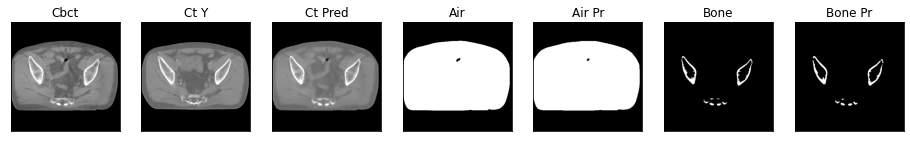

ssim score = 0.7515637278556824
psnr score = 20.400028228759766
snr score = 12.262085914611816
mae error = 0.04192240908741951
air dice score = 0.9982781849048179
bone dice score = 0.9184010571536438


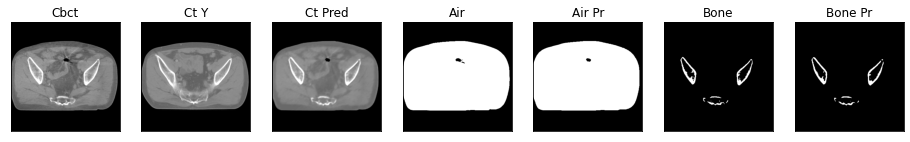

ssim score = 0.743125319480896
psnr score = 20.199796676635742
snr score = 12.09581470489502
mae error = 0.04307640716433525
air dice score = 0.998347227961015
bone dice score = 0.9158739595731885


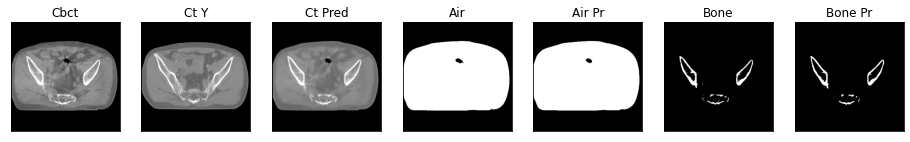

ssim score = 0.7308820486068726
psnr score = 20.10860824584961
snr score = 11.974836349487305
mae error = 0.044251699000597
air dice score = 0.9984641638225266
bone dice score = 0.9080529576107366


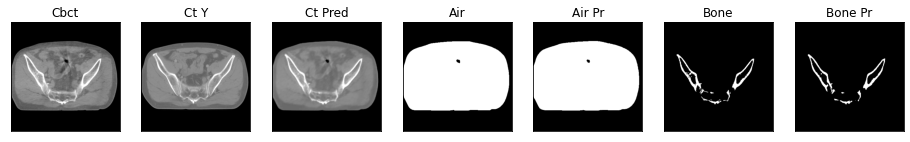

ssim score = 0.731663167476654
psnr score = 20.2814884185791
snr score = 12.08434009552002
mae error = 0.04308609291911125
air dice score = 0.9985396821517395
bone dice score = 0.9059462189129409


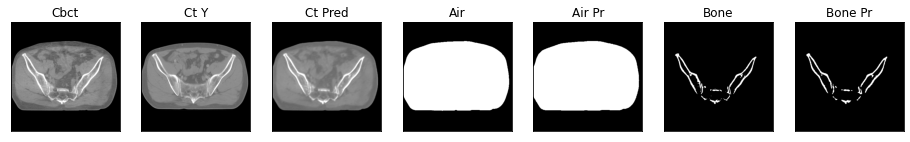

17it [00:38,  2.20s/it]

ssim score = 0.8494927287101746
psnr score = 23.946800231933594
snr score = 15.424193382263184
mae error = 0.025696566328406334
air dice score = 0.9973033268983773
bone dice score = 0.8978610910851013


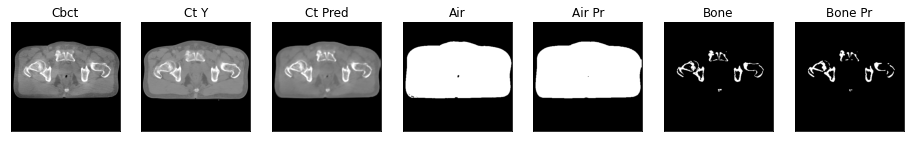

ssim score = 0.85257887840271
psnr score = 24.178661346435547
snr score = 15.696065902709961
mae error = 0.024850253015756607
air dice score = 0.9975846682869222
bone dice score = 0.885115875574605


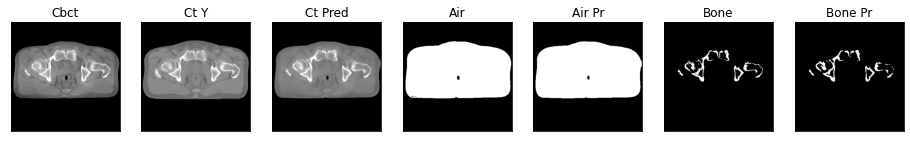

ssim score = 0.8518509864807129
psnr score = 24.415512084960938
snr score = 15.940702438354492
mae error = 0.024665869772434235
air dice score = 0.9975515493042652
bone dice score = 0.8711656441734258


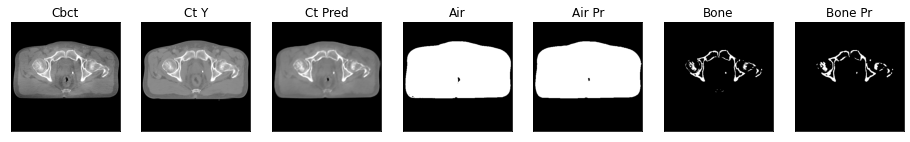

ssim score = 0.8550243973731995
psnr score = 24.487293243408203
snr score = 15.954060554504395
mae error = 0.023562997579574585
air dice score = 0.9981329886543171
bone dice score = 0.8684875466265372


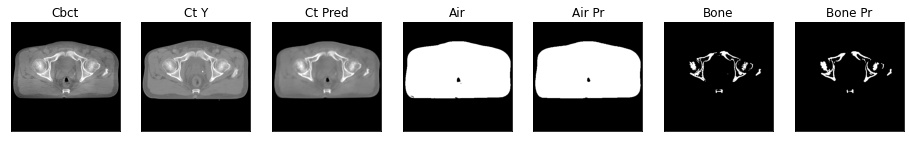

ssim score = 0.8621170520782471
psnr score = 24.65274429321289
snr score = 15.963888168334961
mae error = 0.022161949425935745
air dice score = 0.9978470169054675
bone dice score = 0.8580542264773372


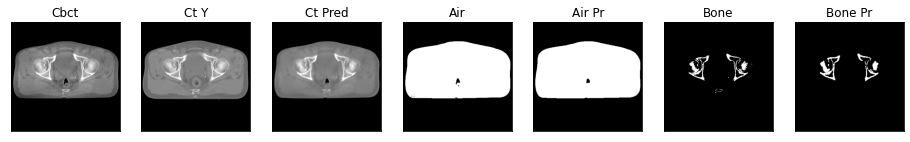

ssim score = 0.8668522238731384
psnr score = 24.84626007080078
snr score = 16.1366024017334
mae error = 0.021565228700637817
air dice score = 0.9980921977729654
bone dice score = 0.8833264943252178


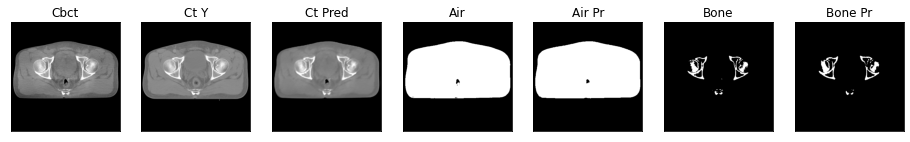

ssim score = 0.8662610054016113
psnr score = 24.895715713500977
snr score = 16.170427322387695
mae error = 0.021498635411262512
air dice score = 0.9978801281073678
bone dice score = 0.8899045570656015


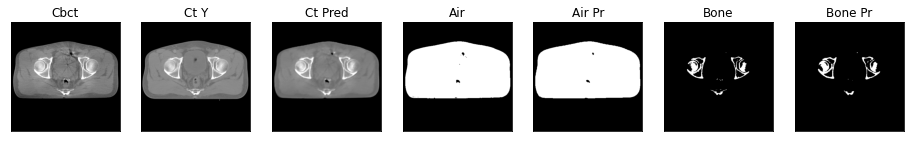

ssim score = 0.8608185648918152
psnr score = 24.228422164916992
snr score = 15.512499809265137
mae error = 0.022810982540249825
air dice score = 0.9972340344021781
bone dice score = 0.9032170857001458


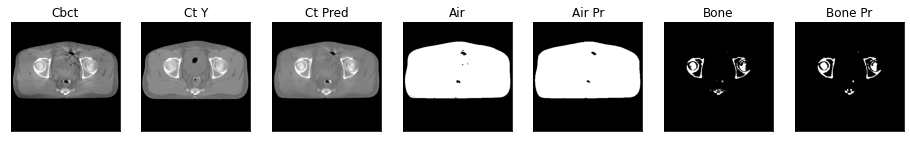

18it [00:40,  2.23s/it]

ssim score = 0.8567133545875549
psnr score = 24.4581298828125
snr score = 15.79798698425293
mae error = 0.02303645946085453
air dice score = 0.9954908934483562
bone dice score = 0.9178538144066323


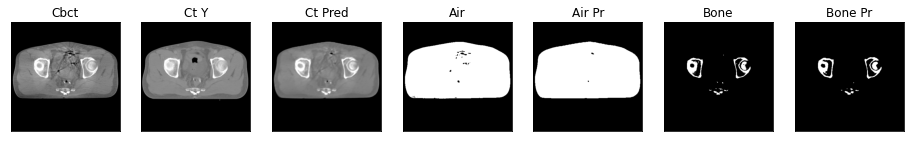

ssim score = 0.8551063537597656
psnr score = 23.770029067993164
snr score = 15.087957382202148
mae error = 0.024344427511096
air dice score = 0.9954189745610208
bone dice score = 0.9198415949758317


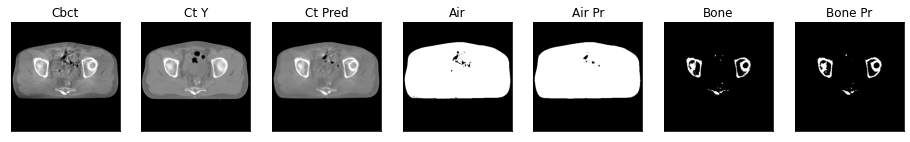

ssim score = 0.8572906255722046
psnr score = 23.0909423828125
snr score = 14.33809757232666
mae error = 0.024703845381736755
air dice score = 0.9954405880710931
bone dice score = 0.9040640580162552


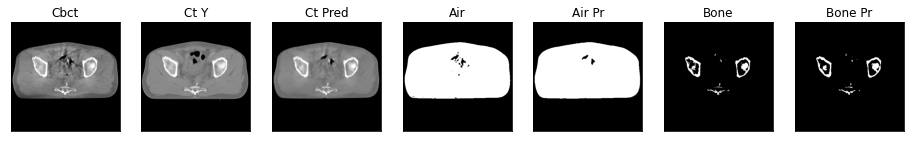

ssim score = 0.8582479953765869
psnr score = 23.602718353271484
snr score = 14.805980682373047
mae error = 0.02371937595307827
air dice score = 0.9961879377673122
bone dice score = 0.899693102892914


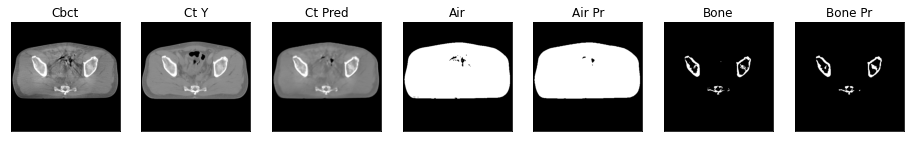

ssim score = 0.861212432384491
psnr score = 23.98868179321289
snr score = 15.190844535827637
mae error = 0.0228357445448637
air dice score = 0.9964083587287794
bone dice score = 0.905719673163015


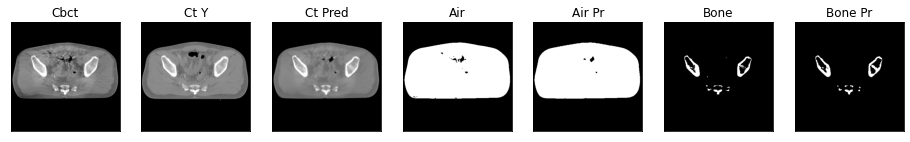

ssim score = 0.8581826090812683
psnr score = 24.178123474121094
snr score = 15.393643379211426
mae error = 0.02295401692390442
air dice score = 0.9952275892284379
bone dice score = 0.9102034572447575


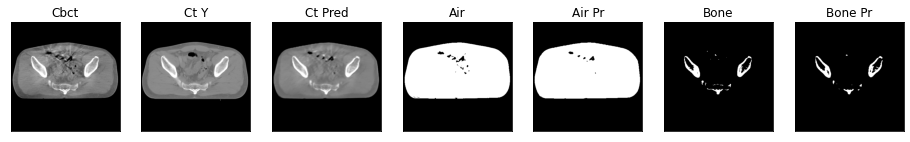

ssim score = 0.8551085591316223
psnr score = 24.040775299072266
snr score = 15.311502456665039
mae error = 0.023541534319519997
air dice score = 0.9954796663600737
bone dice score = 0.9140236912506174


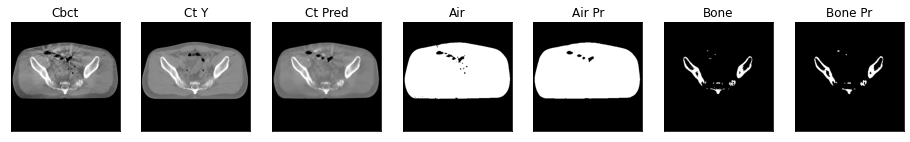

ssim score = 0.8553076386451721
psnr score = 23.35887908935547
snr score = 14.64897346496582
mae error = 0.02449340932071209
air dice score = 0.9962968799243648
bone dice score = 0.904091566900354


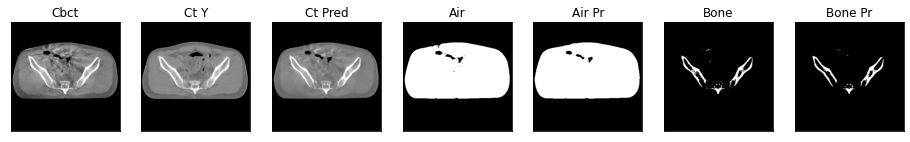

19it [00:42,  2.19s/it]

ssim score = 0.859508216381073
psnr score = 23.483463287353516
snr score = 14.718820571899414
mae error = 0.02376084215939045
air dice score = 0.9959458714801931
bone dice score = 0.8951428571443552


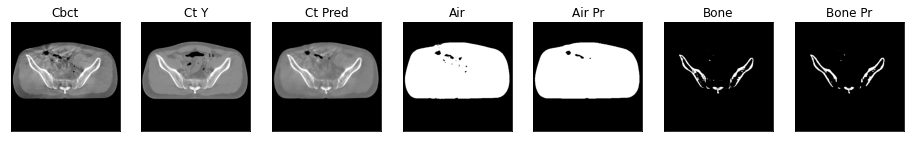

ssim score = 0.8594579696655273
psnr score = 23.70809555053711
snr score = 14.907100677490234
mae error = 0.023562073707580566
air dice score = 0.9963873399827249
bone dice score = 0.876109936576799


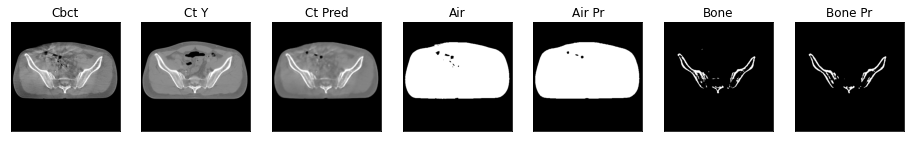

ssim score = 0.8620445728302002
psnr score = 23.796911239624023
snr score = 14.995985984802246
mae error = 0.023120742291212082
air dice score = 0.9965746429300971
bone dice score = 0.8680861786585853


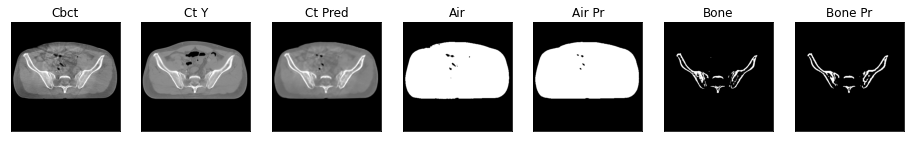

ssim score = 0.8614152669906616
psnr score = 24.140871047973633
snr score = 15.338525772094727
mae error = 0.022792547941207886
air dice score = 0.9963079878140011
bone dice score = 0.8826628968014052


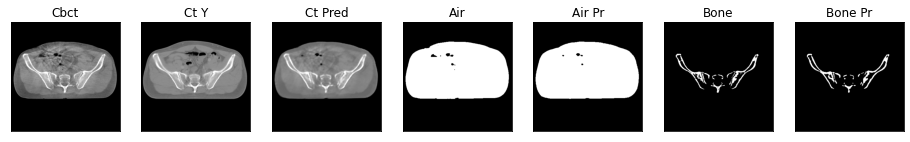

ssim score = 0.8523417115211487
psnr score = 23.515369415283203
snr score = 14.718060493469238
mae error = 0.02408018335700035
air dice score = 0.9955329563275234
bone dice score = 0.8817987690003543


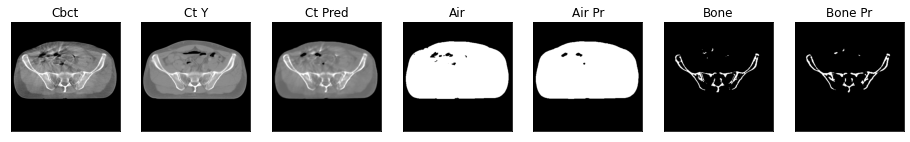

ssim score = 0.8464731574058533
psnr score = 23.0081844329834
snr score = 14.193603515625
mae error = 0.025091147050261497
air dice score = 0.9948674625818935
bone dice score = 0.8744220917171758


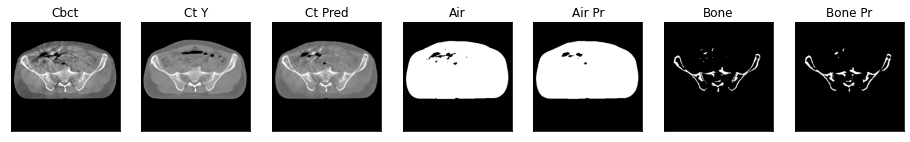

ssim score = 0.8405240774154663
psnr score = 22.54257583618164
snr score = 13.709373474121094
mae error = 0.026586823165416718
air dice score = 0.9949206907860572
bone dice score = 0.8718548858996856


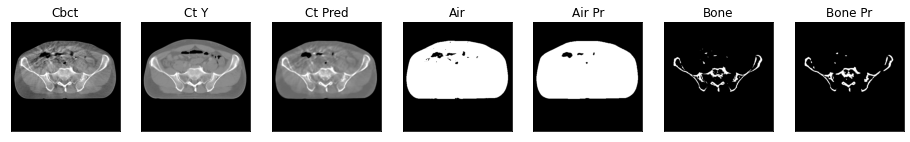

ssim score = 0.8323045372962952
psnr score = 22.052297592163086
snr score = 13.17315673828125
mae error = 0.028328439220786095
air dice score = 0.9949418716680624
bone dice score = 0.8745552622532473


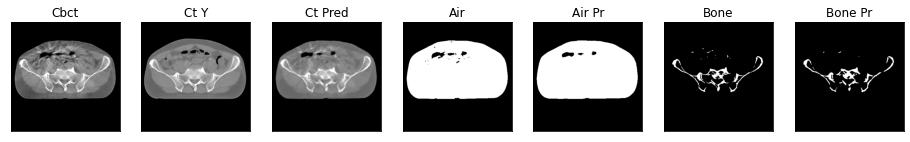

20it [00:44,  2.22s/it]

ssim score = 0.8275054097175598
psnr score = 22.074546813964844
snr score = 13.141607284545898
mae error = 0.02842271327972412
air dice score = 0.994795994933159
bone dice score = 0.881129943504168


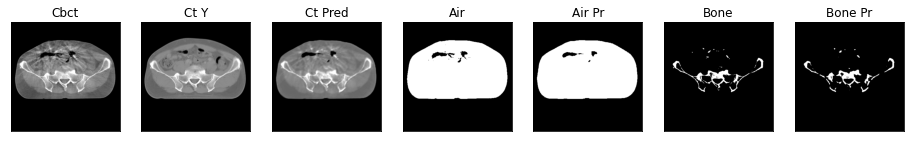

ssim score = 0.8177724480628967
psnr score = 21.63194465637207
snr score = 12.729467391967773
mae error = 0.030631711706519127
air dice score = 0.9949589911498727
bone dice score = 0.8897637795287989


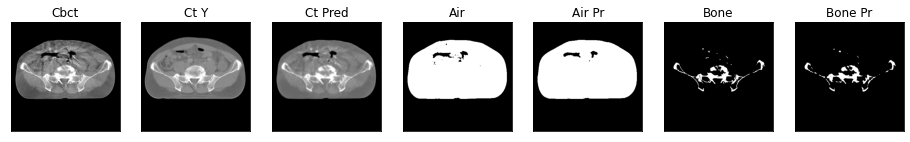

ssim score = 0.8128820657730103
psnr score = 21.346302032470703
snr score = 12.388599395751953
mae error = 0.031086299568414688
air dice score = 0.9953493657119241
bone dice score = 0.8767513654728478


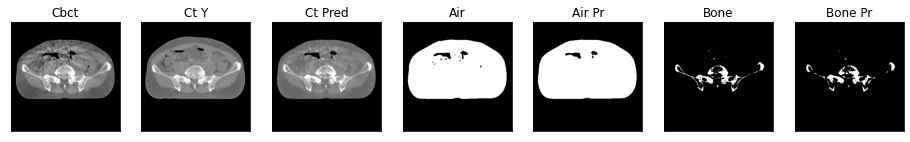

ssim score = 0.823542594909668
psnr score = 22.072294235229492
snr score = 12.967058181762695
mae error = 0.028499891981482506
air dice score = 0.9960426228976467
bone dice score = 0.8905669720241326


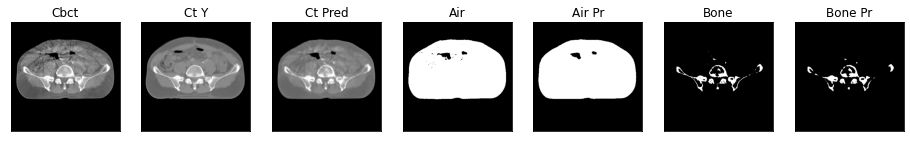

ssim score = 0.879850447177887
psnr score = 26.422374725341797
snr score = 16.803285598754883
mae error = 0.019431347027420998
air dice score = 0.9983922228453929
bone dice score = 0.9309870772633768


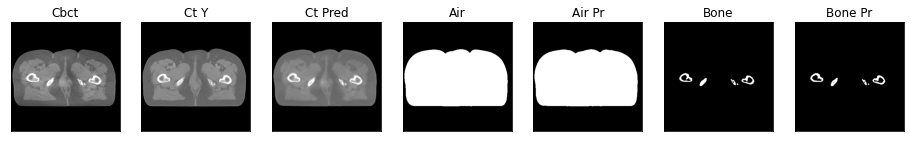

ssim score = 0.879173219203949
psnr score = 26.53588104248047
snr score = 17.037805557250977
mae error = 0.019452732056379318
air dice score = 0.9982536839836825
bone dice score = 0.9276635082059703


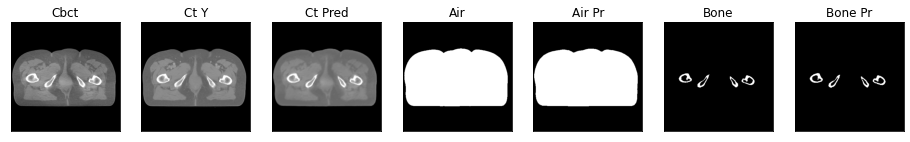

ssim score = 0.8745977282524109
psnr score = 26.440013885498047
snr score = 17.024856567382812
mae error = 0.020055154338479042
air dice score = 0.998160528940274
bone dice score = 0.9136886102421382


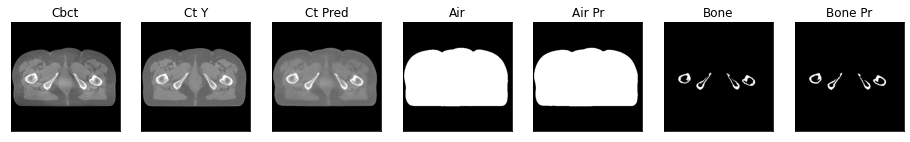

ssim score = 0.8723498582839966
psnr score = 26.34178924560547
snr score = 16.990074157714844
mae error = 0.020428800955414772
air dice score = 0.9979780749803336
bone dice score = 0.9164490861634381


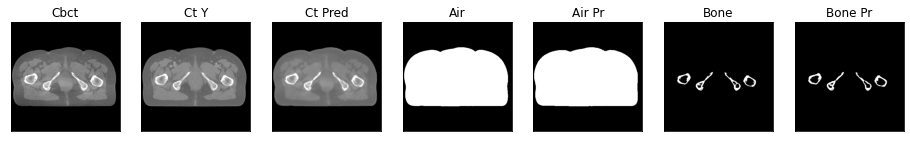

21it [00:47,  2.24s/it]

ssim score = 0.8724724650382996
psnr score = 26.255878448486328
snr score = 16.932626724243164
mae error = 0.020555056631565094
air dice score = 0.9983515879702566
bone dice score = 0.9177737881522842


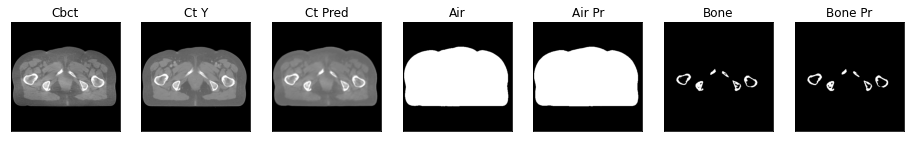

ssim score = 0.8726706504821777
psnr score = 26.17984390258789
snr score = 16.879545211791992
mae error = 0.02053985558450222
air dice score = 0.9983777621887069
bone dice score = 0.91241147968855


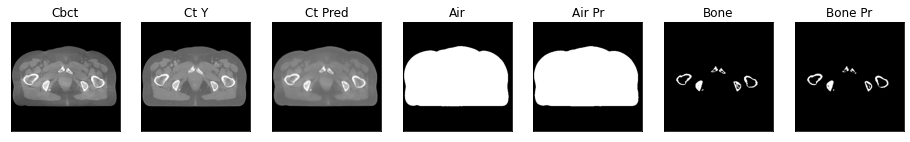

ssim score = 0.8701078295707703
psnr score = 26.073898315429688
snr score = 16.804927825927734
mae error = 0.02073722705245018
air dice score = 0.9985129677955488
bone dice score = 0.9107601909674852


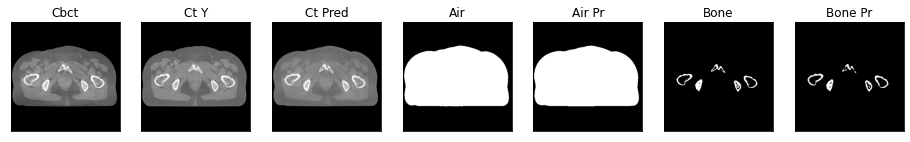

ssim score = 0.8690604567527771
psnr score = 26.031822204589844
snr score = 16.811216354370117
mae error = 0.020973948761820793
air dice score = 0.9973922291341928
bone dice score = 0.9058823529428541


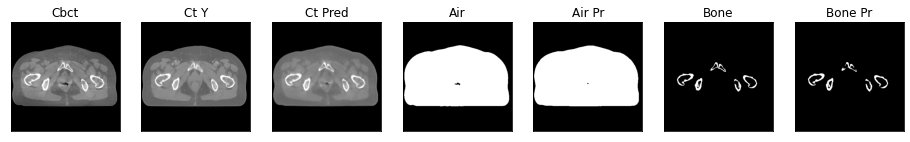

ssim score = 0.8699259757995605
psnr score = 25.602039337158203
snr score = 16.424177169799805
mae error = 0.021257786080241203
air dice score = 0.9978204614207109
bone dice score = 0.9090610097038471


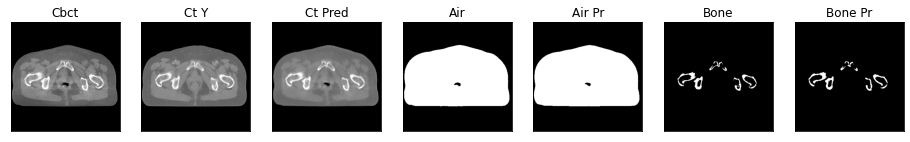

ssim score = 0.8678741455078125
psnr score = 25.534822463989258
snr score = 16.44466209411621
mae error = 0.0216233991086483
air dice score = 0.9977251848287343
bone dice score = 0.8968912645956267


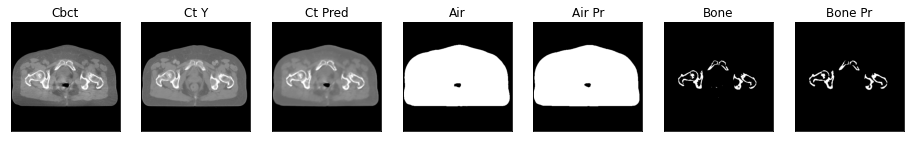

ssim score = 0.8698558807373047
psnr score = 26.381553649902344
snr score = 17.404666900634766
mae error = 0.020981712266802788
air dice score = 0.9975920042937773
bone dice score = 0.905942355593572


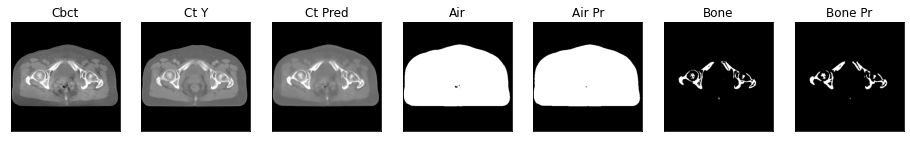

ssim score = 0.8734426498413086
psnr score = 25.751651763916016
snr score = 16.646215438842773
mae error = 0.02097037062048912
air dice score = 0.9972651760906585
bone dice score = 0.8695064232611646


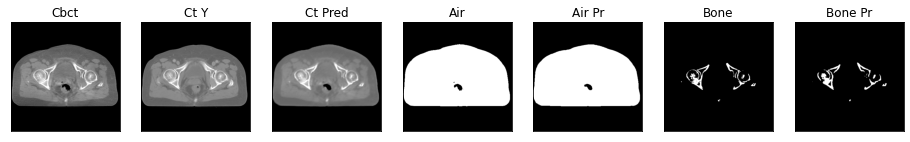

22it [00:49,  2.20s/it]

ssim score = 0.8758320808410645
psnr score = 25.873537063598633
snr score = 16.658676147460938
mae error = 0.02047961764037609
air dice score = 0.9975302543838003
bone dice score = 0.8556981719203481


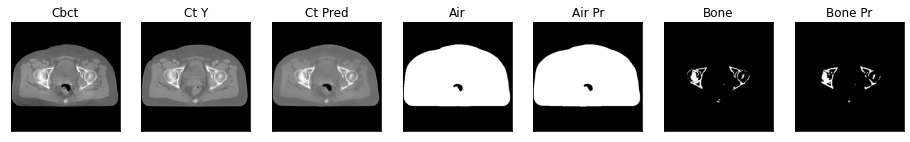

ssim score = 0.8796713948249817
psnr score = 25.86325454711914
snr score = 16.621265411376953
mae error = 0.02106347493827343
air dice score = 0.9973000166486928
bone dice score = 0.8878939211316016


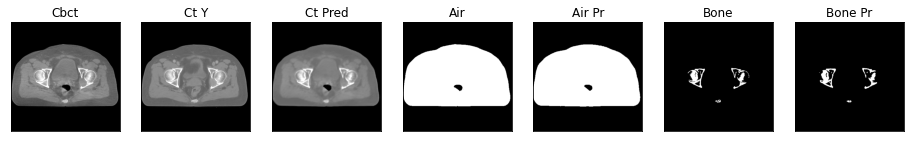

ssim score = 0.8818734884262085
psnr score = 26.480987548828125
snr score = 17.230995178222656
mae error = 0.021034324541687965
air dice score = 0.9975531525584284
bone dice score = 0.9011206328295794


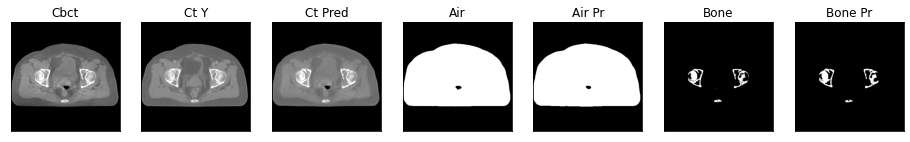

ssim score = 0.8821212649345398
psnr score = 27.136028289794922
snr score = 17.920263290405273
mae error = 0.02009117230772972
air dice score = 0.9978175096861353
bone dice score = 0.9199684293619579


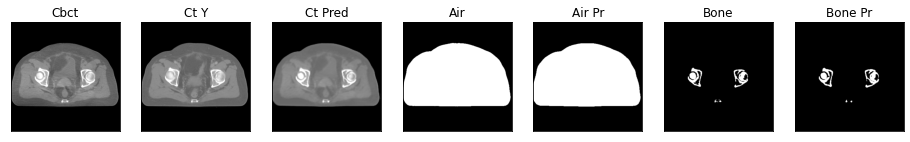

ssim score = 0.8746184706687927
psnr score = 26.41811752319336
snr score = 17.25384521484375
mae error = 0.02105345018208027
air dice score = 0.9977771662044599
bone dice score = 0.9373615944331325


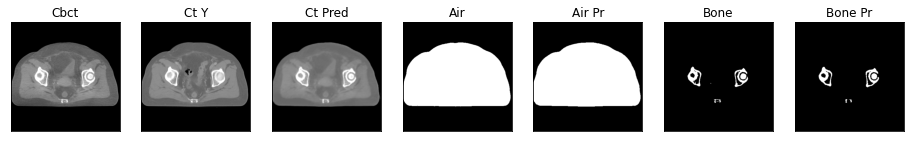

ssim score = 0.8626466989517212
psnr score = 25.505558013916016
snr score = 16.378843307495117
mae error = 0.022206217050552368
air dice score = 0.9976838731798129
bone dice score = 0.9364201796831993


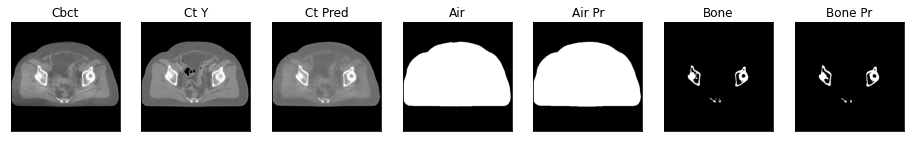

ssim score = 0.8473991751670837
psnr score = 23.998199462890625
snr score = 14.799049377441406
mae error = 0.024965975433588028
air dice score = 0.9964677087389466
bone dice score = 0.9222867351513558


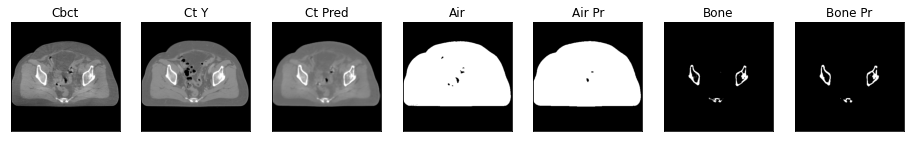

ssim score = 0.8420079350471497
psnr score = 23.6229248046875
snr score = 14.405780792236328
mae error = 0.02634998969733715
air dice score = 0.9962158160900482
bone dice score = 0.9167611703352969


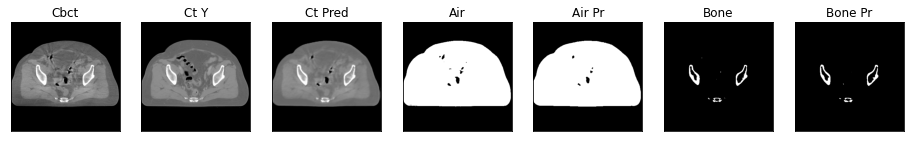

23it [00:51,  2.23s/it]

ssim score = 0.8405795693397522
psnr score = 24.26548957824707
snr score = 15.113260269165039
mae error = 0.025532478466629982
air dice score = 0.9961663791451052
bone dice score = 0.9234126118279857


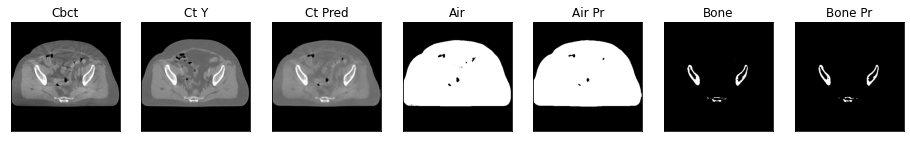

ssim score = 0.8411905765533447
psnr score = 24.28388786315918
snr score = 15.186753273010254
mae error = 0.025841539725661278
air dice score = 0.9957906171498433
bone dice score = 0.916082591401476


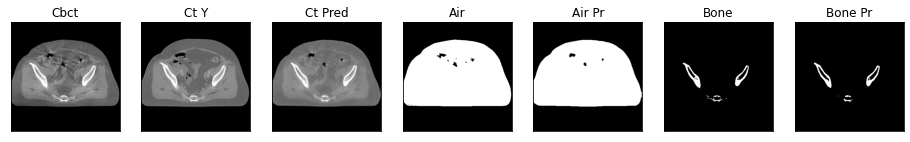

ssim score = 0.8356216549873352
psnr score = 23.55703353881836
snr score = 14.524330139160156
mae error = 0.027502892538905144
air dice score = 0.9960760599341557
bone dice score = 0.913689535252708


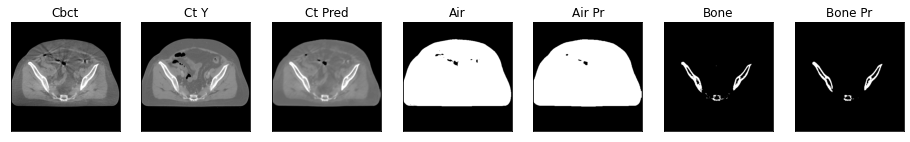

ssim score = 0.8349612951278687
psnr score = 23.547080993652344
snr score = 14.587238311767578
mae error = 0.027732739225029945
air dice score = 0.9956803455723571
bone dice score = 0.911789894377508


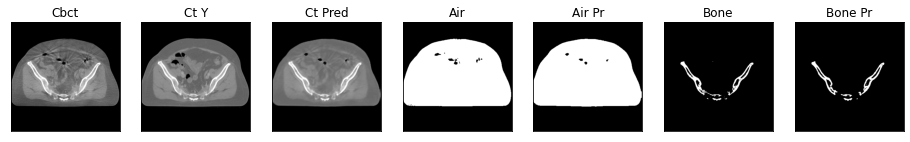

ssim score = 0.8335139751434326
psnr score = 23.470699310302734
snr score = 14.506564140319824
mae error = 0.028304941952228546
air dice score = 0.9958172287817044
bone dice score = 0.8982122260683649


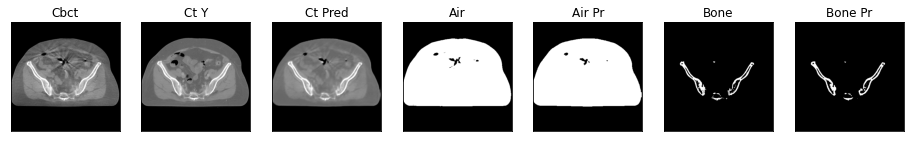

ssim score = 0.8339001536369324
psnr score = 23.519454956054688
snr score = 14.533143043518066
mae error = 0.028419528156518936
air dice score = 0.996092036788534
bone dice score = 0.8869565217407159


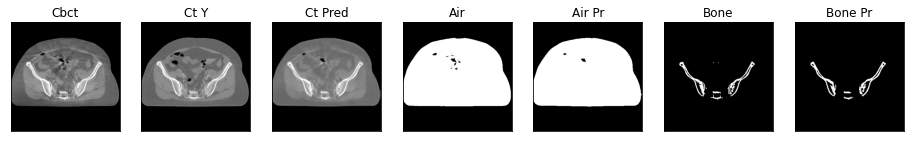

ssim score = 0.8404902219772339
psnr score = 24.264598846435547
snr score = 15.289918899536133
mae error = 0.026779359206557274
air dice score = 0.9969083991729826
bone dice score = 0.8878238729985349


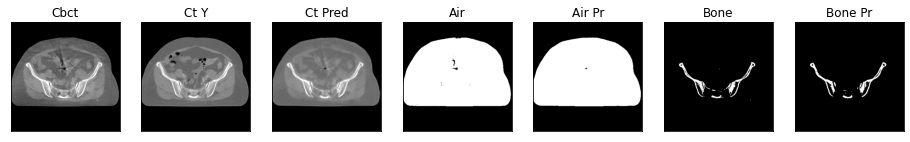

24it [00:53,  2.22s/it]


In [32]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [33]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [34]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [35]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:07,  3.39it/s]


(0.8472007513046265,
 23.785436153411865,
 14.800006628036499,
 0.025992155230293672,
 0.9954523483015062,
 0.9113073427916101,
 0.3333333333333333)